# Модель прогнозирования стоимости жилья для агентства недвижимости

### Постановка задачи

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

**Задача** - разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок, увеличила бы число сделок и прибыль агентства.

### Этапы работы над проектом:

1. Провести разведывательный анализ и очистку исходных данных. Обратите внимание, что данные в таблице реальные: в результате во многих признаках присутствуют дублирующиеся категории, ошибки ввода, жаргонные сокращения и т .д. Вам предстоит отыскать закономерности, самостоятельно расшифровать все сокращения, найти синонимы в данных, обработать пропуски и удалить выбросы.
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные
о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

### Описание данных

- 'status' — статус продажи;
- 'private pool' и 'PrivatePool' — наличие собственного бассейна;
- 'propertyType' — тип объекта недвижимости;
- 'street' — адрес объекта;
- 'baths' — количество ванных комнат;
- 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
- 'fireplace' — наличие камина;
- 'city' — город;
- 'schools' — сведения о школах в районе;
- 'sqft' — площадь в футах;
- 'zipcode' — почтовый индекс;
- 'beds' — количество спален;
- 'state' — штат;
- 'stories' — количество этажей;
- 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
- 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [2]:
# Импорт базовых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sweetviz as sv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import optuna
from sklearn.model_selection import cross_val_score
import ast
import requests
import json
from flask import Flask, jsonify, request
from joblib import load
from prettytable import PrettyTable
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
import joblib

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [4]:
data = pd.read_csv('data/data-2.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


## Основная информация

In [5]:
# Общая информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [6]:
# Основные статистические характеристики числовых столбцов
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462



1. В датасете имеется 377,185 записей и 18 признаков.
Многие признаки имеют пропущенные значения, причем их количество может быть значительным в некоторых столбцах.
2. Типы данных:
Все признаки имеют тип данных object, что может свидетельствовать о том, что необходимо преобразовать некоторые признаки в более подходящие типы данных.
3. Пропущенные значения:
Признаки 'private pool', 'baths', 'fireplace', 'sqft', 'beds', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target' содержат пропущенные значения.
Необходимо решить, как обработать пропущенные значения для каждого из этих признаков: заполнение средним значением, медианой, удаление или использование других методов обработки.
4. Статистические характеристики:
Некоторые признаки, такие как 'status', 'private pool', 'propertyType', 'baths', 'fireplace', 'city', 'state', 'stories', 'PrivatePool', имеют огромное количество уникальных значений. Это может потребовать дополнительного анализа и обработки.
5. Целевая переменная 'target' содержит в себе строки с символами доллара ('$') и представляет из себя цену недвижимости. Требуется преобразование этого признака в числовой формат для дальнейшего использования в модели.
7. Дополнительные действия:
Провести десериализацию признаков 'homeFacts' и 'schools'. Произвести преобразование типов данных, где это необходимо.

## Sweetviz 

                                             |          | [  0%]   00:00 -> (? left)

Report report.html was generated.



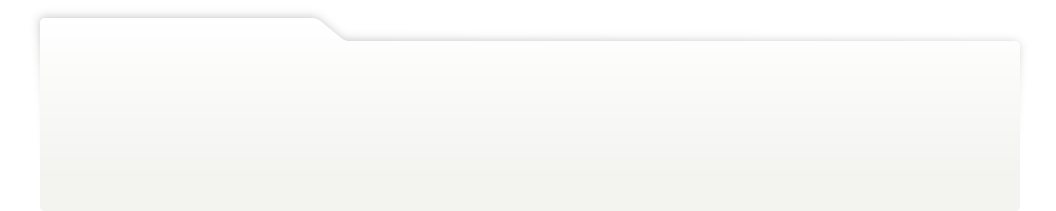
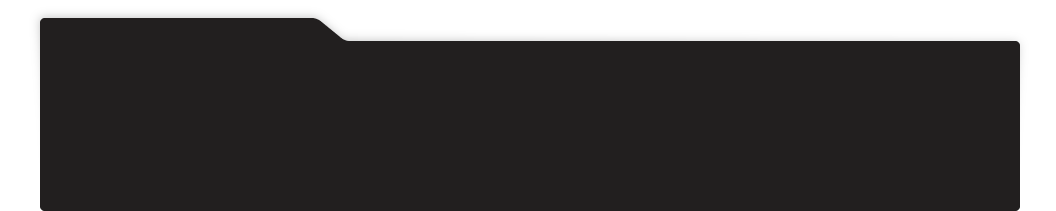
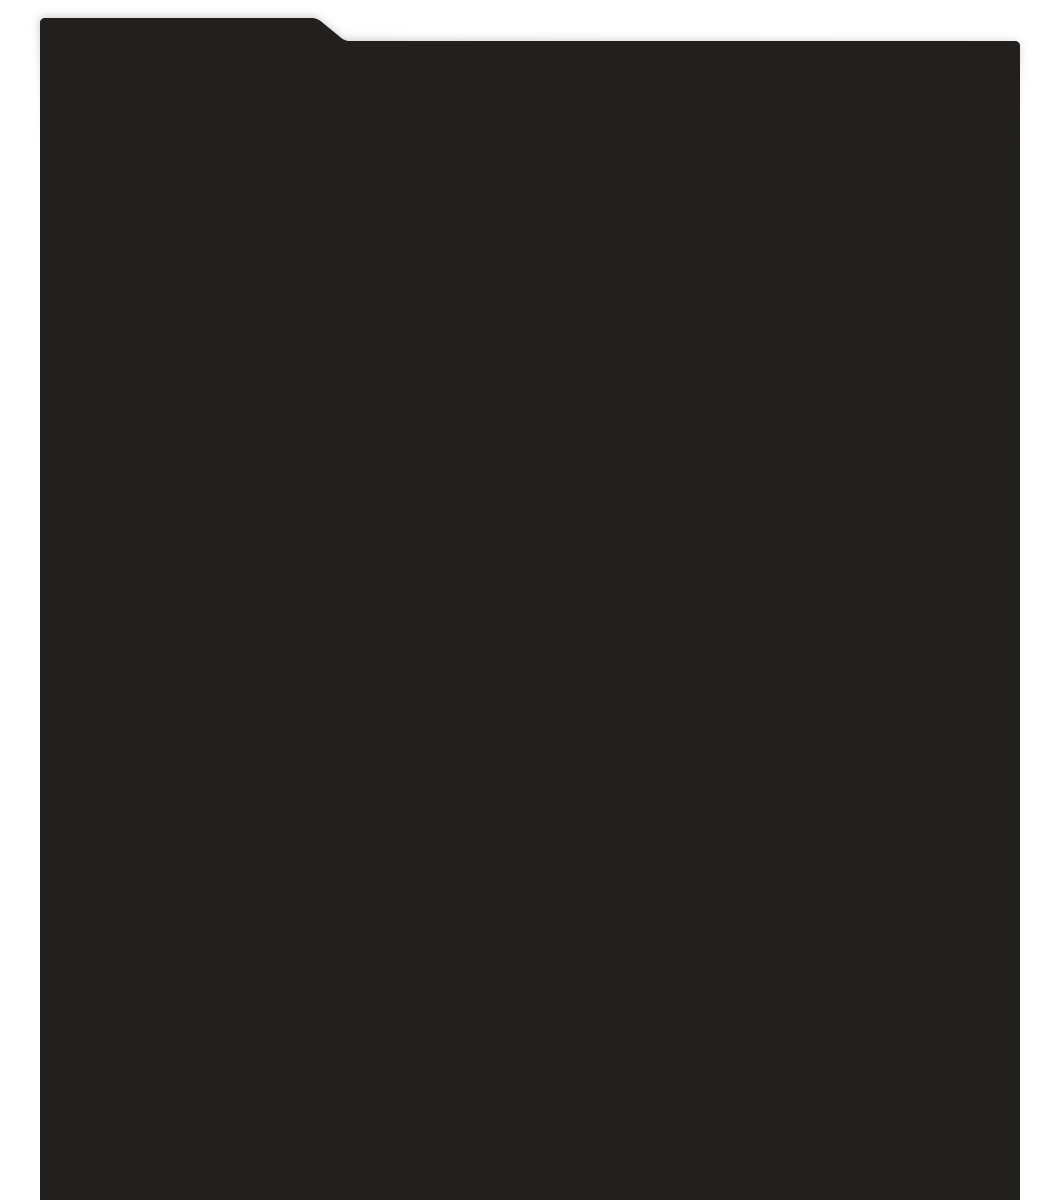
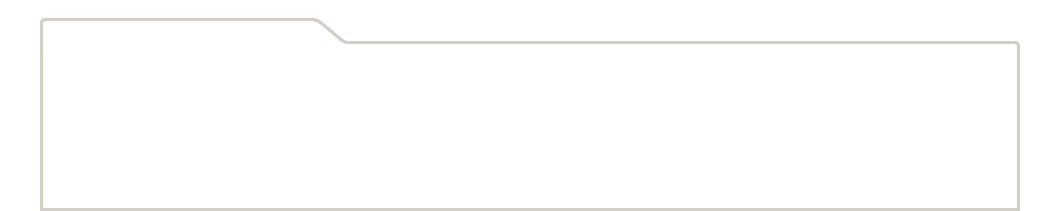
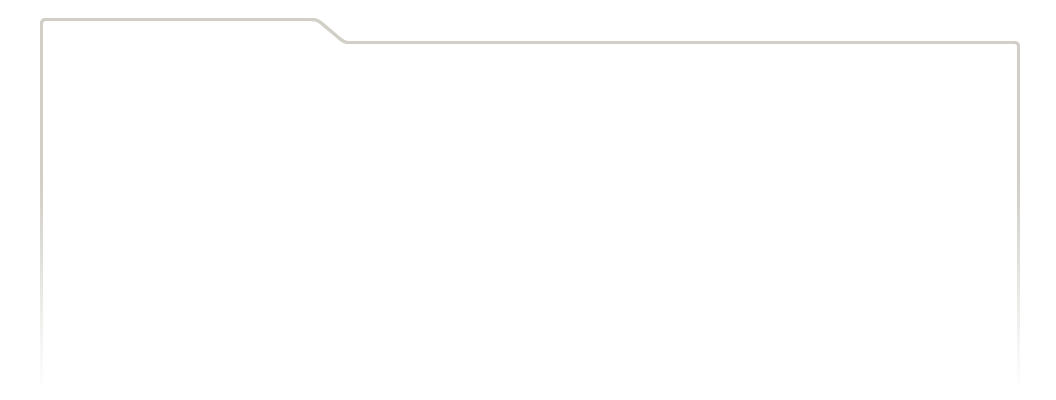
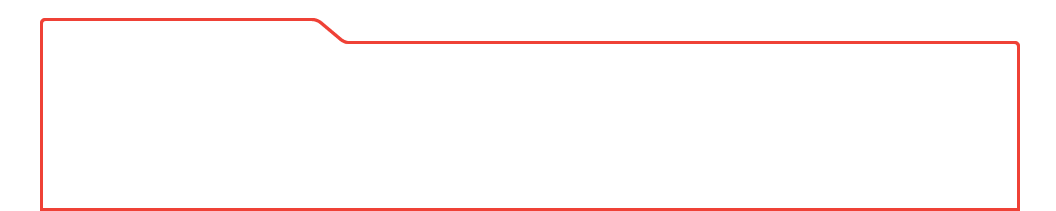
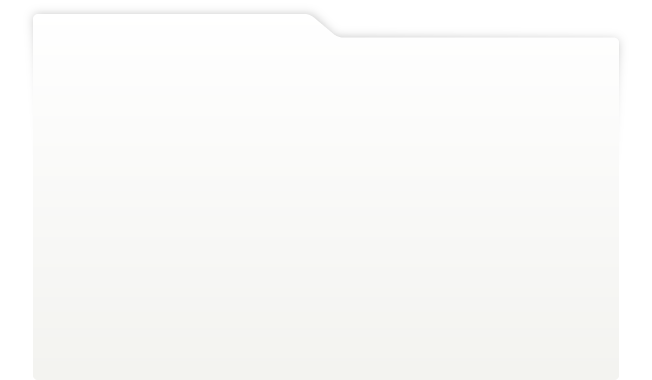
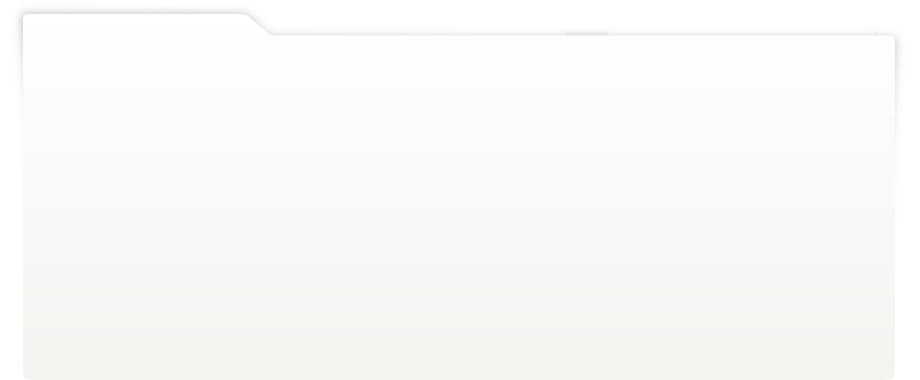
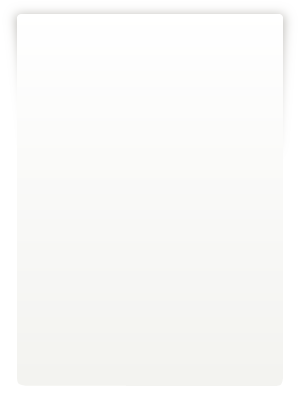
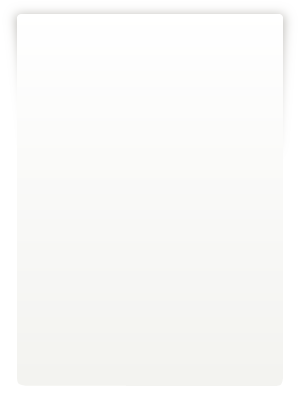
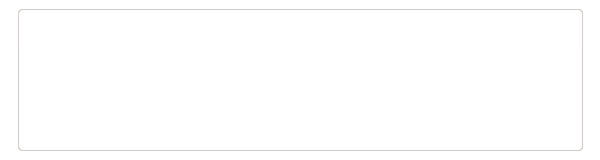
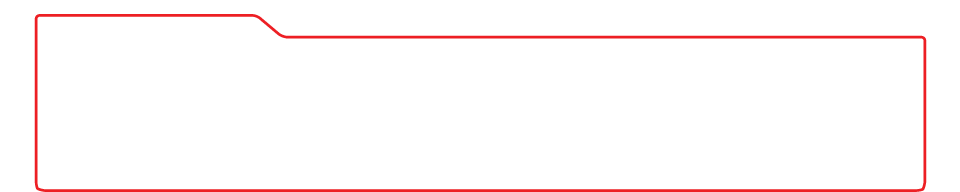
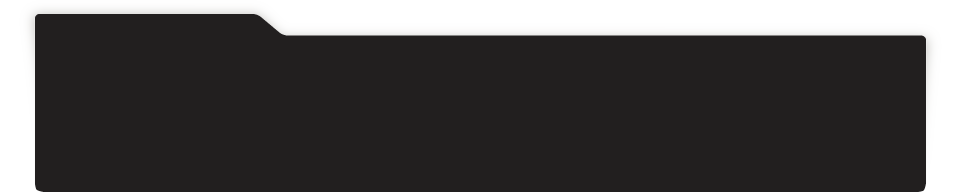
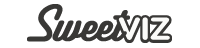
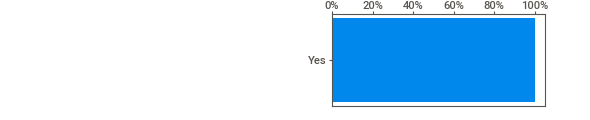
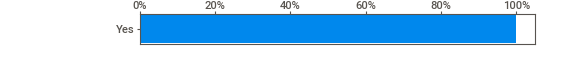
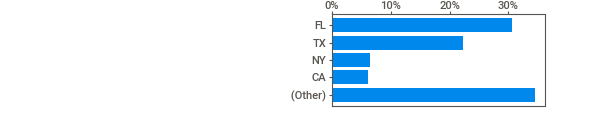
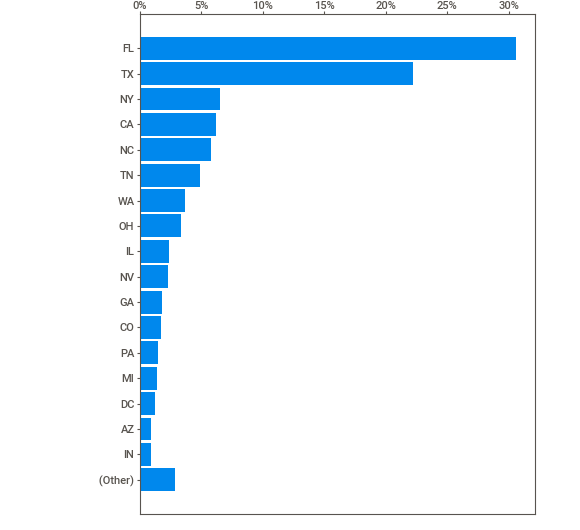
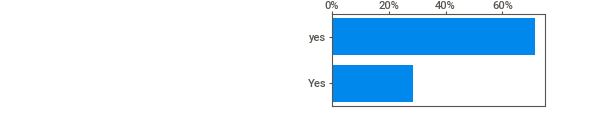
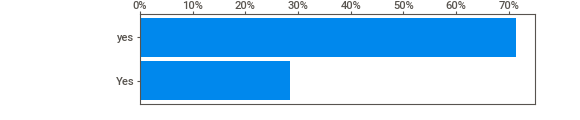
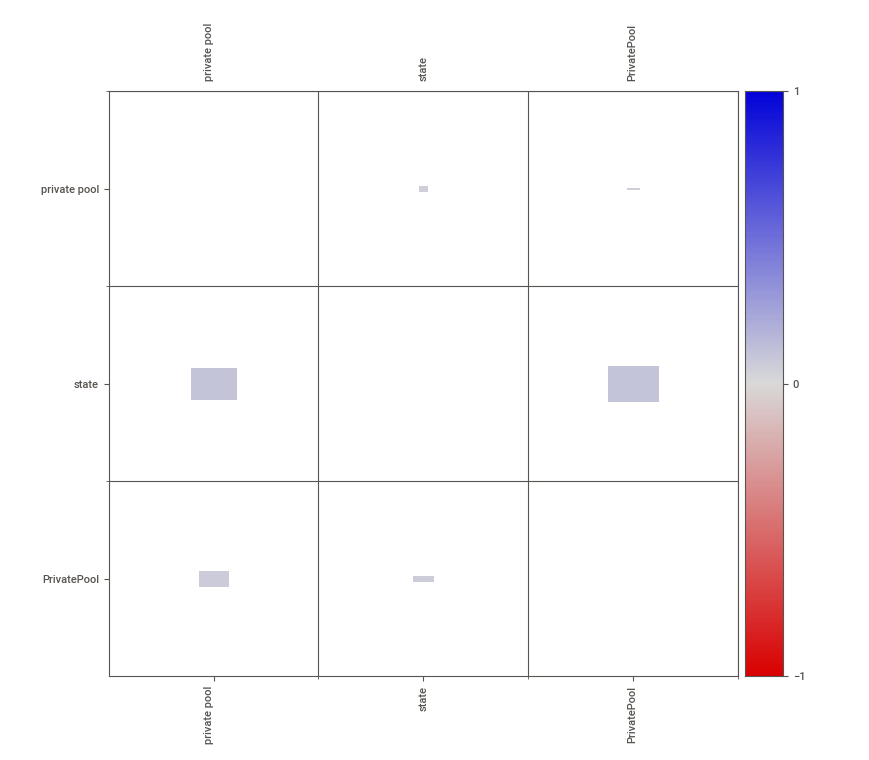
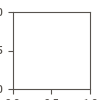

In [7]:
# Используем sweetviz для ознаковления с данными
report = sv.analyze(data)
report.show_html('report.html', open_browser=False)
report.show_notebook()

# Очистка данных

### Обработка дубликатов:

In [7]:
# Посчитаем дубликаты в DataFrame
duplicate_count = data.duplicated().sum()

print(f'Количество дубликатов в данных: {duplicate_count}')

Количество дубликатов в данных: 50


In [8]:
# Удаляем дубликаты
data.drop_duplicates(inplace=True)

In [9]:
# Проверяем
duplicate_count = data.duplicated().sum()
duplicate_count

0

### Обработка пропущенных значений:

In [10]:
# Проверяем пропущенные значения
data.isnull().sum()

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274024
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150674
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

In [11]:
# Выведем пропущенные значения в %
missing_data = data.isnull().sum()

for column_name, missing_count in missing_data.items():
    if missing_count > 0:
        percentage = (missing_count / len(data)) * 100
        print(f'{column_name}: {missing_count} пропусков ({percentage:.2f}%)')


status: 39917 пропусков (10.58%)
private pool: 372954 пропусков (98.89%)
propertyType: 34733 пропусков (9.21%)
street: 2 пропусков (0.00%)
baths: 106308 пропусков (28.19%)
fireplace: 274024 пропусков (72.66%)
city: 34 пропусков (0.01%)
sqft: 40550 пропусков (10.75%)
beds: 91254 пропусков (24.20%)
stories: 150674 пропусков (39.95%)
mls-id: 352193 пропусков (93.39%)
PrivatePool: 336825 пропусков (89.31%)
MlsId: 66869 пропусков (17.73%)
target: 2480 пропусков (0.66%)


In [12]:
# Уникальные значения "mls-id"
unique_values_mls_id = data['mls-id'].nunique()
print(f'Уникальных значений в "mls-id": {unique_values_mls_id}')

# Уникальность в процентном отношении "mls-id"
percentage_unique_mls_id = (unique_values_mls_id / len(data['mls-id'].dropna())) * 100
print(f'Уникальность в процентах для "mls-id": {percentage_unique_mls_id:.2f}%')

# Уникальные значения "MlsId"
unique_values_mlsid = data['MlsId'].nunique()
print(f'Уникальных значений в "MlsId": {unique_values_mlsid}')

# Уникальности в процентном отношении "MlsId"
percentage_unique_mlsid = (unique_values_mlsid / len(data['MlsId'].dropna())) * 100
print(f'Уникальность в процентах для "MlsId": {percentage_unique_mlsid:.2f}%')

Уникальных значений в "mls-id": 24907
Уникальность в процентах для "mls-id": 99.86%
Уникальных значений в "MlsId": 232944
Уникальность в процентах для "MlsId": 75.08%


Из данных следует, что у нас есть значительное количество пропущенных значений в некоторых столбцах. Важно рассмотреть стратегии обработки пропусков для каждого из этих столбцов, в зависимости от их значения для моделирования. 

1. **'private pool'** и **'PrivatePool'**:
Признак "наличие бассейна" в исходных данных представлен двумя столбцами: 'private pool' и 'PrivatePool'. Оба столбца содержат значительное количество пропущенных значений — 99% и 89% соответственно. Даже объединение этих столбцов не снизит общий процент пропусков до приемлемого уровня. В связи с этим было принято решение удалить данный признак из датасета. 

2. Признак **"fireplace"** содержит 73% пропусков - удалим данный признак из датасета.

3. **"mls-id"**, представляющий систему мультилистинга, содержит 93% пропусков, в то время как его дубликат **"MlsId"** обладает только 18% пропусками. Слияние этих двух столбцов может снизить общий процент пропусков до приемлемого уровня. Тем не менее, стоит отметить высокий процент уникальных значений в этих столбцах. Вероятно, эти признаки не несут существенной информации, и их можно рассмотреть для удаления из датасета.


In [13]:
# Удаляем признаки
data.drop(['mls-id', 'MlsId', 'fireplace', 'private pool', 'PrivatePool'], axis=1, inplace=True)

# Удаляем строки с пропусками в целевом признаке 'target'
data.dropna(axis=0, subset=['target'], inplace=True)

# Удаляем строки с пропусками в признаке 'city'
data.dropna(axis=0, subset=['city'], inplace=True)
data.shape

(374621, 13)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374621 entries, 0 to 377184
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335366 non-null  object
 1   propertyType  340067 non-null  object
 2   street        374619 non-null  object
 3   baths         269299 non-null  object
 4   homeFacts     374621 non-null  object
 5   city          374621 non-null  object
 6   schools       374621 non-null  object
 7   sqft          334526 non-null  object
 8   zipcode       374621 non-null  object
 9   beds          283717 non-null  object
 10  state         374621 non-null  object
 11  stories       224896 non-null  object
 12  target        374621 non-null  object
dtypes: object(13)
memory usage: 40.0+ MB


### Baseline

In [15]:
# Выбираем признаки для baseline модели
selected_features = ['status', 'propertyType', 'sqft', 'beds']

# Создаем DataFrame с выбранными признаками
baseline_data = data[selected_features + ['target']].copy()

# Преобразуем 'status' и 'propertyType' с использованием one-hot encoding
baseline_data = pd.get_dummies(baseline_data, columns=['status', 'propertyType'], drop_first=True)
# Заменяем символ '+' и другие нежелательные символы в столбце 'sqft'
baseline_data['sqft'] = baseline_data['sqft'].replace('[^0-9]', '', regex=True)

# Преобразуем столбец 'sqft' в числовой формат
baseline_data['sqft'] = pd.to_numeric(baseline_data['sqft'], errors='coerce')
# Заменяем пропущенные значения в числовых признаках
baseline_data['sqft'].fillna(baseline_data['sqft'].median(), inplace=True)
baseline_data['beds'] = pd.to_numeric(baseline_data['beds'], errors='coerce')
baseline_data['beds'].fillna(baseline_data['beds'].median(), inplace=True)

# Убираем символы '$' и ','
baseline_data['target'] = baseline_data['target'].replace('[\$,]', '', regex=True)

# Оставим только цифры и десятичные точки
baseline_data['target'] = baseline_data['target'].replace('[^\d.]', '', regex=True)

# Преобразуем столбец 'target' в числовой формат
baseline_data['target'] = pd.to_numeric(baseline_data['target'], errors='coerce')

# Разделим данные на обучающую и тестовую выборки
X = baseline_data.drop('target', axis=1)
y = baseline_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создадим и обучим модель линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_linear = linear_model.predict(X_test)

# Оценим метрики линейной регрессии
baseline_mae_linear = mean_absolute_error(y_test, y_pred_linear)
baseline_mape_linear = mean_absolute_percentage_error(y_test, y_pred_linear)
baseline_mse_linear = mean_squared_error(y_test, y_pred_linear) 
baseline_r2_linear = r2_score(y_test, y_pred_linear)

# Выведем метрики
print("Baseline Linear Regression Metrics:")
print(f"MAE: {baseline_mae_linear}")
print(f"MAPE: {baseline_mape_linear}")
print(f"MSE: {baseline_mse_linear}")
print(f"R2: {baseline_r2_linear}")

Baseline Linear Regression Metrics:
MAE: 575873.2576953818
MAPE: 10.401878695905667
MSE: 26838938113139.9
R2: -7.60679309868093


In [16]:
# Создаем и обучаем модель градиентного бустинга
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_gb = gb_model.predict(X_test)

# Оценим метрики градиентного бустинга
baseline_mae_gb = mean_absolute_error(y_test, y_pred_gb)
baseline_mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)
baseline_mse_gb = mean_squared_error(y_test, y_pred_gb) 
baseline_r2_gb = r2_score(y_test, y_pred_gb)

# Выведем метрики
print("Baseline Gradient Boosting Regressor Metrics:")
print(f"MAE: {baseline_mae_gb}")
print(f"MAPE: {baseline_mape_gb}")
print(f"MSE: {baseline_mse_gb}")
print(f"R2: {baseline_r2_gb}")

Baseline Gradient Boosting Regressor Metrics:
MAE: 431039.41706402745
MAPE: 8.745751313945334
MSE: 2134189631889.2837
R2: 0.3156015145760125


### Обработка признака 'status'

In [17]:
# Выводим уникальные значения
unique_statuses = data['status'].unique()

print(unique_statuses)

['Active' 'for sale' nan 'New construction' 'New' 'For sale' 'Pending' 'P'
 'Active/Contingent' ' / auction' 'Under Contract'
 'Pre-foreclosure / auction' 'Under Contract   Showing' 'Pre-foreclosure'
 'Under Contract Backups' 'Active Under Contract' 'foreclosure'
 'Foreclosed' 'Option Pending' 'Under Contract Show' 'for rent' 'Auction'
 'A Active' 'Contingent' 'Pending   Continue To Show' 'Price Change'
 'Back on Market' 'Active Option' 'Foreclosure' 'Coming soon: Nov 21.'
 'Contingent Finance And Inspection' 'Coming soon: Dec 4.'
 'P Pending Sale' 'Coming soon: Nov 23.' 'Active With Contingencies'
 'Pending Ab' 'Pf' 'Contingent Show' 'Contract P' 'Contingent Take Backup'
 'Apartment for rent' 'Backup Contract' 'Option Contract'
 'Pending Continue To Show' 'pending' 'Pending Inspection'
 'Active Option Contract' 'C' 'Auction - Active' 'Contingent   Show' 'Pi'
 'Due Diligence Period' 'Contract Contingent On Buyer Sale'
 'U Under Contract' 'Coming soon: Nov 29.' 'Coming soon: Dec 2.'
 'A

In [18]:
# Количество уникальных значений 
data['status'].value_counts()

status
for sale                   156054
Active                     105176
For sale                    43462
foreclosure                  5677
New construction             5458
                            ...  
Coming soon: Oct 29.            1
Coming soon: Dec 15.            1
Pending W/Backup Wanted         1
Pending Backups Wanted          1
Coming soon: Dec 23.            1
Name: count, Length: 156, dtype: int64

In [19]:
# Функция преобразования статуса недвижимости
def transform_status(value):
    
    value_lower = str(value).lower()

    if any(keyword in value_lower for keyword in ['active', 'for sale']):
        return 'Active'
    elif 'new' in value_lower:
        return 'New'
    elif any(keyword in value_lower for keyword in ['pending', 'auction', 'contingent', 'under contract', 'pre-foreclosure']):
        return 'Pending'
    elif any(keyword in value_lower for keyword in ['foreclosure', 'foreclosed']):
        return 'Foreclosure'
    elif 'a active' in value_lower:
        return 'Active'
    elif any(keyword in value_lower for keyword in ['price change', 'back on market']):
        return 'Price Change / Back on Market'
    elif 'coming soon' in value_lower:
        return 'Coming Soon'
    else:
        return 'Other'

# Применяем функцию к столбцу 'status'
data['status'] = data['status'].apply(transform_status)

# Выводим уникальные значения после преобразования
unique_statuses_transformed = data['status'].unique()
print(unique_statuses_transformed)

# Выводим количество значений каждой категории
print(data['status'].value_counts())

['Active' 'Other' 'New' 'Pending' 'Foreclosure'
 'Price Change / Back on Market' 'Coming Soon']
status
Active                           306042
Other                             41455
Pending                           13877
Foreclosure                        6314
New                                6148
Price Change / Back on Market       675
Coming Soon                         110
Name: count, dtype: int64


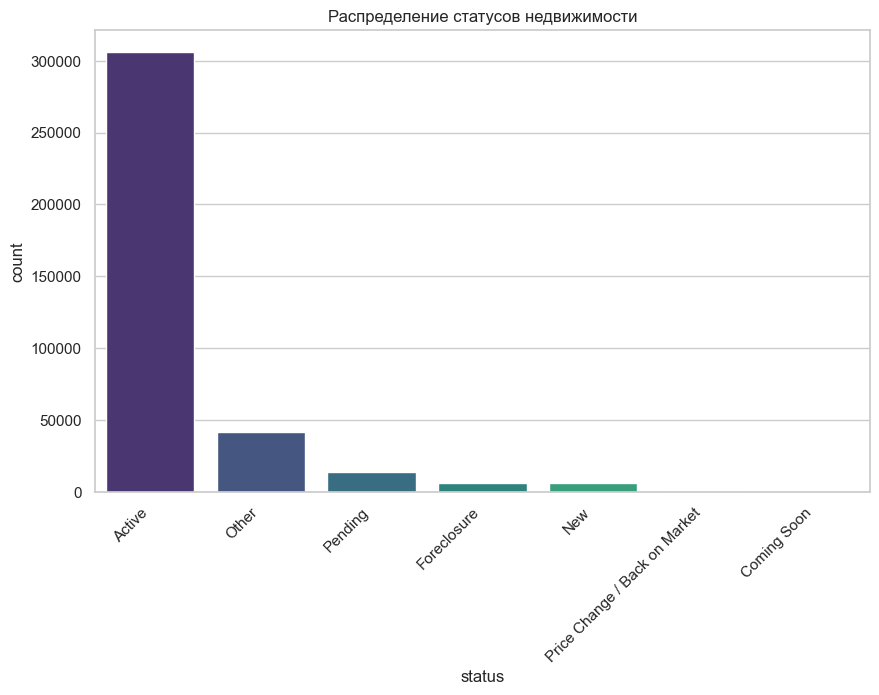

In [20]:
# Установим стиль seaborn для более красочных графиков
sns.set(style="whitegrid")

# Сгруппируем данные по статусу и посчитаем количество для каждого статуса
status_counts = data['status'].value_counts().reset_index()
status_counts.columns = ['status', 'count']

# Строим график с использованием seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='status', y='count', data=status_counts, palette='viridis')
plt.title('Распределение статусов недвижимости')
plt.xticks(rotation=45, ha='right')
plt.show()

1. Большинство недвижимости в датасете имеют статус 'Active', что означает, что они находятся в активной продаже.
2. После обработки, категории статусов недвижимости стали более четкими, сведены к основным категориям 'Active', 'Pending', 'Foreclosure' и др.
3. Столбец 'status' теперь содержит категориальные данные, что может быть полезным при дальнейшем анализе и моделировании.

### Обработка признака 'propertyType'

In [21]:
# Выводим уникальные значения 
unique_prorertytype = data['propertyType'].unique()

print(unique_prorertytype)

['Single Family Home' 'single-family home' 'lot/land' ...
 'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam'
 'Lake House, Single Detached, Tudor'
 'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit']


In [22]:
# Количество уникальных значений
data['propertyType'].value_counts()

propertyType
single-family home                                             91370
Single Family                                                  61884
Single Family Home                                             31720
condo                                                          25874
lot/land                                                       20506
                                                               ...  
1 Story, Contemporary, Other (See Remarks)                         1
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: count, Length: 1279, dtype: int64

In [23]:
# Функция для преобразования значений в 'propertyType'
def transform_property_type(value):
    value_lower = str(value).lower()

    if any(keyword in value_lower for keyword in ['manufactured home', 'mobile', 'prefab', 'modular']):
        return 'Mobile'
    elif 'cabin' in value_lower:
        return 'Cabin'
    elif 'midcentury' in value_lower:
        return 'Midcentury'
    elif 'single family' in value_lower:
        return 'Single Family'

    return value

# Применяем функцию 
data['propertyType'] = data['propertyType'].apply(transform_property_type)

# Выделяем 5 основных типов недвижимости
property_type_mapping = {
    'Single family': ['single', 'bunga', 'cluster', 'colon', 'cape',
                      'contemp', 'cottage', 'craft', 'farm', 'federal',
                      'french', 'feder', 'florida', 'garden', 'historic',
                      'mediter', 'mobile', 'other', 'ranch', 'spanish',
                      'split', 'tradit', 'transit', 'tudor', 'victor',
                      'Low.Rise', '1 Sto', 'One Sto', '2 Sto', 'Two Sto'],
    'Multifamily': ['multi'],
    'Townhouse': ['town', 'co-op'],
    'Condo': ['condo', 'apart', 'coop', 'Mid.Rise', 'High.Rise'],
    'Land': ['land', 'lot']
}

# Заменяем значения в признаке 'propertyType'
for property_type, keywords in property_type_mapping.items():
    mask = data['propertyType'].str.lower().str.contains('|'.join(keywords), na=False)
    data.loc[mask, 'propertyType'] = property_type

# Создаем отдельную категорию 'Other' для всех остальных значений
data['propertyType'] = data['propertyType'].where(data['propertyType'].isin(property_type_mapping.keys()), 'Other')

# Проверяем уникальные значения после обработки
print(data['propertyType'].value_counts())

propertyType
Single family    213051
Condo             47115
Other             44219
Land              31417
Townhouse         26419
Multifamily       12400
Name: count, dtype: int64


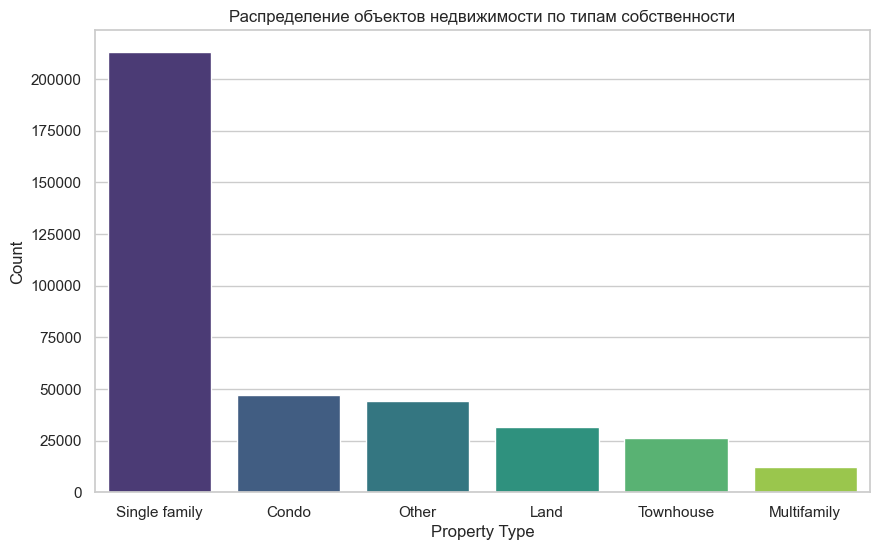

In [24]:
# Создаем DataFrame для использования seaborn
property_type_counts = data['propertyType'].value_counts().reset_index()
property_type_counts.columns = ['Property Type', 'Count']

# Строим график 
plt.figure(figsize=(10, 6))
sns.barplot(x='Property Type', y='Count', data=property_type_counts, palette='viridis')
plt.title('Распределение объектов недвижимости по типам собственности')
plt.show()

In [25]:
# Функция для обработки этажности
def process_stories(data):
    # Выбираем строки, в которых 'propertyType' содержит 'stor' и 'stories' равен NaN
    story_rows = data[(data['propertyType'].str.contains('stor', case=False, na=False)) & (data['stories'].isna())]
    
    # Заменяем NaN в 'stories' значениями из 'propertyType'
    data.loc[story_rows.index, 'stories'] = story_rows['propertyType'].apply(lambda s: story_num(s))

    # Заменяем значения в 'stories' согласно вашим условиям
    data['stories'] = data['stories'].replace({
        'Low.Rise': 'Low Rise (1-3 Stories)',
        'Mid.Rise': 'Mid Rise (4-7 Stories)',
        'High.Rise': 'High Rise (8+ Stories)'
    })

    return data

# Применяем функцию для обработки этажности
data = process_stories(data)

In [26]:
data.head()

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,target
0,Active,Single family,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000"
1,Active,Single family,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000"
2,Active,Single family,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000"
3,Active,Single family,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000"
4,Active,Land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000"


После обработки признака 'propertyType' была достигнута категоризация разнообразных описаний типов недвижимости. Значения были преобразованы в более общие категории, такие как 'Single family', 'Condo', 'Other', 'Land', 'Townhouse' и 'Multifamily', что значительно облегчит анализ данных и улучшит их интерпретацию.

Выделение основных типов недвижимости позволяет лучше понять структуру данных. Например, 'Single family' является наиболее распространенной категорией, в то время как 'Condo' и 'Other' также представлены значительными объемами записей. Визуализация распределения категорий наглядно демонстрирует соотношение между разными типами недвижимости.

### Обработка признака 'baths'

In [27]:
# Выводим уникальные значения
unique_baths = data['baths'].unique()

print(unique_baths)

['3.5' '3 Baths' '2 Baths' '8 Baths' nan '2' '3' 'Bathrooms: 2' '1,750'
 '4 Baths' '2 ba' 'Bathrooms: 5' '1,000' '7 Baths' '2.0' '3.0'
 'Bathrooms: 1' '4.0' '2.1 Baths' '2.5 Baths' '1' 'Bathrooms: 3' '4.5'
 '6 Baths' 'Bathrooms: 4' '3 ba' '5' '2,500' '5.5 Baths' '1.0' '5 Baths'
 '1.5' '4' '~' '2.5' '4,000' '3.5 Baths' '2,000' '3,000' '8.0' '1 ba' '0'
 '5.0' '1,500' '7.0' '1,250' '9 Baths' '2,250' '6.0' '12 Baths' '5.5'
 '3,500' '1.5 Baths' '2,750' 'Bathrooms: 6' '4.5 Baths' '750' '5.5+' '6'
 '10 Baths' '6 ba' 'Bathrooms: 19' '10.0' '4 ba' '12 ba' '2.5+' '8' '7.5+'
 'Bathrooms: 10' '0 / 0' 'Sq. Ft. ' '5 ba' '4.5+' '18 Baths' '-- baths'
 'Bathrooms: 7' '7' '18' '3.5+' '1.5+' '11 Baths' '5,000' '1.75 Baths' '9'
 '12.0' '6.5' 'Bathrooms: 8' '10' '19 Baths' 'Bathrooms: 9' '16 Baths'
 '13 Baths' 'Bathrooms: 13' '14' '9.0' '8.5+' '7 ba' '12' '1.1 Baths'
 '2.5 ba' 'Bathrooms: 12' '17' 'Bathrooms: 241' '16.0' '10.5+' '8 ba'
 '6.5+' '6.5 Baths' '14 Baths' '3.5 ba' '7,500+' '7.5' '11.0' '20 Baths

In [28]:
# Количество уникальных значений
data['baths'].value_counts()

baths
2 Baths       52072
3 Baths       35393
2             20427
2.0           16354
4 Baths       14723
              ...  
0.5 Baths         1
4.75 Baths        1
5.25 Baths        1
41.0              1
44.0              1
Name: count, Length: 226, dtype: int64

In [29]:
# Функция для преобразования значений в признаке 'baths'
def convert_baths(bath_value):
    if pd.isna(bath_value):
        return np.nan
    
    # Находим числовое значение в строке, используя регулярное выражение
    bath_count = re.search(r'\d+(\.\d+)?', str(bath_value))
    
    if bath_count:
        return float(bath_count.group())
    else:
        return np.nan

# Применяем функцию к столбцу 'baths'
data['baths'] = data['baths'].apply(convert_baths)

In [30]:
# Находим медианное значение
median_baths = data['baths'].median()

# Заменяем пропущенные значения медианой 
data['baths'] = data['baths'].fillna(median_baths)
print("Количество пропущенных значений в 'baths':", data['baths'].isnull().sum())

Количество пропущенных значений в 'baths': 0


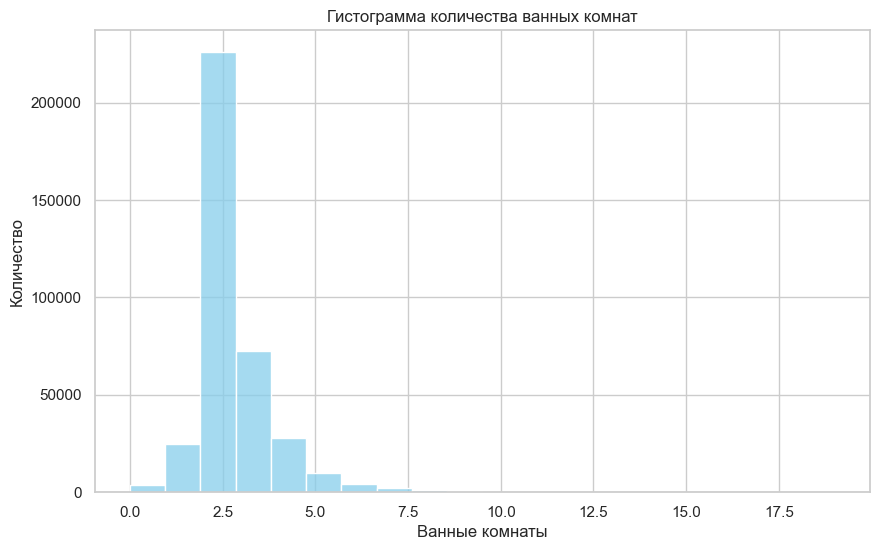

In [31]:
# Строим график
plt.figure(figsize=(10, 6))
sns.histplot(data[data['baths'] < 20]['baths'], bins=20, kde=False, color='skyblue')
plt.title('Гистограмма количества ванных комнат')
plt.xlabel('Ванные комнаты')
plt.ylabel('Количество')
plt.show()

In [32]:
# Описательные статистики для признака 'baths'
before_outlier_stats = data['baths'].describe()

# Определим верхнюю границу выбросов
Q1 = data['baths'].quantile(0.25)
Q3 = data['baths'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Выбросы
outliers = data[data['baths'] > upper_bound]

# Заменяем выбросы медианным значением
median_baths = data['baths'].median()
data.loc[outliers.index, 'baths'] = median_baths

# Описательные статистики для признака 'baths' после обработки выбросов
after_outlier_stats = data['baths'].describe()

# Сравним статистики
comparison_stats = pd.DataFrame({
    'Before Outlier Handling': before_outlier_stats,
    'After Outlier Handling': after_outlier_stats,
})

print(comparison_stats)

       Before Outlier Handling  After Outlier Handling
count            374621.000000           374621.000000
mean                  2.976924                2.284570
std                  18.843333                0.741507
min                   0.000000                0.000000
25%                   2.000000                2.000000
50%                   2.000000                2.000000
75%                   3.000000                3.000000
max                 750.000000                4.500000


Результаты после обработки выбросов в признаке 'baths' выглядят гораздо лучше. Среднее значение уменьшилось с 2.98 до 2.28, стандартное отклонение также уменьшилось, что указывает на более сосредоточенное распределение данных. Медиана осталась неизменной, что подтверждает, что обработка выбросов влияла преимущественно на хвостовые значения.

Это улучшение позволит более точно отражать средний уровень ванных комнат, уменьшая влияние выбросов. Обработка выбросов обеспечивает более стабильные и интерпретируемые результаты в анализе данных.

### Обработка признака 'sqft' 

In [33]:
# Уникальные значений признака
unique_sqft = data['sqft'].unique()

print(unique_sqft)

['2900' '1,947 sqft' '3,000 sqft' ... '4371' '13,870 sqft'
 'Total interior livable area: 4,615 sqft']


In [34]:
# Количество уникальных значений признака
data['sqft'].value_counts()

sqft
0                                          11824
1,200 sqft                                   829
1,000 sqft                                   648
1,100 sqft                                   570
1,800 sqft                                   562
                                           ...  
Total interior livable area: 5,190 sqft        1
Total interior livable area: 5,150 sqft        1
12,160 sqft                                    1
18,400 sqft                                    1
Total interior livable area: 4,615 sqft        1
Name: count, Length: 25371, dtype: int64

In [35]:
# Функция для преобразования значений площади
def convert_sqft(sqft_value):
    if pd.isna(sqft_value):
        return np.nan
    
    # Извлекаем числовые значения из строки
    sqft_match = re.findall(r'\d+', str(sqft_value))
    
    if sqft_match:
        # Преобразуем каждое найденное значение в числовой формат
        sqft_numbers = [int(match) for match in sqft_match]
        return np.sum(sqft_numbers)
    
    return np.nan

# Применяем функцию к столбцу 'sqft'
data['sqft'] = data['sqft'].apply(convert_sqft)

In [36]:
# Выводим количество пропущенных значений
print(data['sqft'].isnull().sum())

40905


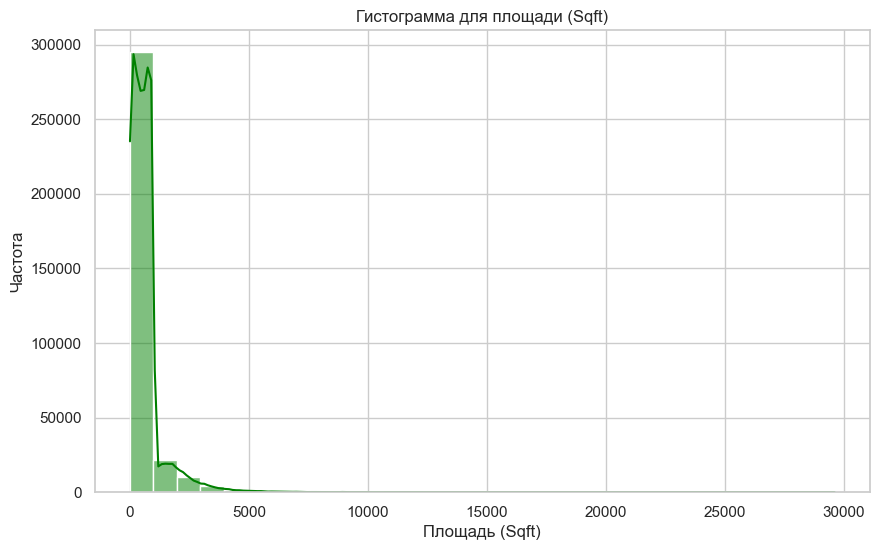

In [37]:
# Удаляем выбросы для более четкой визуализации
data_no_outliers = data[(data['sqft'] >= 0) & (data['sqft'] <= 30000)]

# Гистограмма для признака 'sqft'
plt.figure(figsize=(10, 6))
sns.histplot(data_no_outliers['sqft'], bins=30, kde=True, color='green')
plt.title('Гистограмма для площади (Sqft)')
plt.xlabel('Площадь (Sqft)')
plt.ylabel('Частота')
plt.show()

In [38]:
# Рассчитаем границы выбросов
Q1 = data['sqft'].quantile(0.25)
Q3 = data['sqft'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для определения выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Посчитаем количество выбросов
outliers_count = len(data[(data['sqft'] < lower_bound) | (data['sqft'] > upper_bound)])

# Выводим результат
print('Количество выбросов:', outliers_count)
print('Границы выбросов:', lower_bound, upper_bound)

Количество выбросов: 21734
Границы выбросов: -663.0 1729.0


In [120]:
# Заполняем пропущенные значения медианным значением
data['sqft'].fillna(data['sqft'].median(), inplace=True)

1. Удалены запятые из значений, преобразованы в числовой формат, и нулевые значения заменены на NaN.
2. Теперь столбец 'sqft' содержит числовые значения, представляющие площадь в квадратных футах.
3. Уникальные значения столбца 'sqft' представляют различные числовые значения, что говорит о разнообразии площадей в данных.

### Обработка признака 'zipcode'

In [39]:
# Уникальные значения 
unique_zipcode = data['zipcode'].unique()

print(unique_zipcode)

['28387' '99216' '90049' ... '20191' '64015' '44704']


In [40]:
# Количество уникальных значений
data['zipcode'].value_counts()

zipcode
32137         2139
33131         1561
34747         1484
78245         1383
34759         1333
              ... 
27707-4206       1
41831            1
61736            1
27615-1459       1
44704            1
Name: count, Length: 4541, dtype: int64

In [41]:
# Проверяем наличие дубликатов
duplicate_zipcodes = data[data.duplicated(subset=['zipcode'], keep=False)]
print("Количество дубликатов в 'zipcode':", duplicate_zipcodes.shape[0])

# Проверяем наличие пропущенных значений
missing_zipcodes = data['zipcode'].isnull().sum()
print("Количество пропущенных значений в 'zipcode':", missing_zipcodes)

Количество дубликатов в 'zipcode': 374027
Количество пропущенных значений в 'zipcode': 0


In [42]:
# Удаляем столбец 'zipcode'
data.drop('zipcode', axis=1, inplace=True)

Удаление столбца 'zipcode' позволит сократить размер данных и избавиться от избыточной информации. Было много дубликатов в столбце 'zipcode', что подчеркивает его ограниченную информационную ценность.  Во-первых, в датасете большое количество дубликатов, что говорит о том, что эта информация могла быть зашумленной или избыточной. Во-вторых, столбец 'zipcode' не несет сильной информационной нагрузки и, скорей всего, его удаление не повлияет на анализ данных.

### Обработка признака 'street'

In [43]:
# Количество уникальныз значений в признаке
unique_streets = data['street'].nunique()
total_records = len(data)

percentage_unique = (unique_streets / total_records) * 100

print(f"Количество уникальных значений в 'street': {unique_streets}")
print(f"Процент уникальных значений в 'street': {percentage_unique:.2f}%")

Количество уникальных значений в 'street': 334725
Процент уникальных значений в 'street': 89.35%


Признак 'street' содержит 89% уникальных значений, представляя собой улицу, где находится недвижимость. Эта информация может быть полезна для отображения объекта на карте, но вероятность ее использования в прогнозировании цен на недвижимость крайне низка. Учитывая, что у нас уже есть отдельный признак 'city', который указывает на город, можно рассмотреть возможность удаления признака 'street'. Такой шаг позволит уменьшить размерность данных, не потеряв при этом важную информацию для прогнозирования цен.

In [44]:
# Удаляем столбец 'street'
data = data.drop(['street'], axis=1)

### Обработка признака 'stories'

In [45]:
# Уникальные значений 
unique_stories= data['stories'].unique()

print(unique_stories)

[nan '2.0' '1.0' '3.0' 'One' '2' 'Multi/Split' '4.0' '0.0' '0' 'One Level'
 '1' '9.0' '3' '1 Level, Site Built' 'One Story' '3.00' '1.00' '14.0'
 'Two' '3+' '1 Story' '5.0' '2 Story' 'Ranch/1 Story' 'Condominium'
 'Stories/Levels' '7.0' '2 Level, Site Built' '2 Level' '15'
 '3 Level, Site Built' '4' '22.0' '2.00' '6.0' '1.0000' 'Lot' '3 Story'
 'Three Or More' '1.5' '1 Level' 'Two Story or More'
 'Site Built, Tri-Level' '54.0' '23' 'Farm House' '8.0' '16.0' '1.50' '18'
 '9' '21' '8' '12.0' 'Split Level w/ Sub' '11.0' '1.5 Stories' '7' '11'
 'Townhouse' '12' '21.0' '16' '1.5 Story/Basement' '28.0' 'Traditional'
 '2.5 Story' '17' '2.0000' '63.0' 'Acreage' 'Ground Level, One' '6'
 'Split Foyer' '2 Stories' '27.0' '19.0' '2.50' '1.30' '2 Story/Basement'
 'Split Level' '1.5 Story' '1.5 Level' '2 Or More Stories'
 '1 Level, Condo, Site Built' '15.0' '20' '1.5000' '4.00'
 '1 Story Basement' '5' 'Multi-Level' '17.0' 'Other Multi-unit' 'Ranch'
 'Tri-Level' '13.0' '1 Story/Ranch' '51.0' '18.0' '

In [46]:
# Количество уникальных значений
data['stories'].value_counts()

stories
1.0                                  66805
2.0                                  55003
1                                    22794
2                                    17972
3.0                                  11230
                                     ...  
1.2                                      1
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
78                                       1
65.0                                     1
Name: count, Length: 346, dtype: int64

In [47]:
# Заменяем строковые значения на числовые
data['stories'] = pd.to_numeric(data['stories'], errors='coerce')

# Заменяем One, Two, Three и т.д. на соответствующие числа
word_mapping = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9, 'Ten': 10}
data['stories'] = data['stories'].replace(word_mapping)

# Приводим к целочисленному типу
data['stories'] = data['stories'].astype(np.float64).astype(pd.Int64Dtype(), errors='ignore')

# Заменяем NaN на "Unknown"
data['stories'] = data['stories'].fillna(np.nan)

# Группируем по заданным категориям
categories_mapping = {
    'Low Rise (1-3 Stories)': [0, 1, 2, 3],
    'Mid Rise (4-7 Stories)': [4, 5, 6, 7],
    'High Rise (8+ Stories)': [8, 9, 10],
    'Unknown': [np.nan]
}

def categorize_stories(value):
    for category, values in categories_mapping.items():
        if pd.notna(value) and value in values:
            return category
    return 'Unknown'

# Применяем функцию категоризации
data['stories'] = data['stories'].apply(categorize_stories)

# Заменяем NaN на "Unknown"
data['stories'] = data['stories'].replace({np.nan: 'Unknown'})

# Выводим уникальные значения и их количество
print(data['stories'].value_counts())


stories
Low Rise (1-3 Stories)    194328
Unknown                   171224
Mid Rise (4-7 Stories)      5279
High Rise (8+ Stories)      3790
Name: count, dtype: int64


In [48]:
print('Пропуски в признаке stories: ', data['stories'].isna().sum())

Пропуски в признаке stories:  0


После обработки признака stories пропуски были успешно устранены.
Это улучшенное представление этажности позволит более эффективно анализировать и использовать данные в дальнейших исследованиях и моделях машинного обучения.

### Обработка признака 'beds'

In [49]:
# Уникальные значения 
unique_beds= data['beds'].unique()

print(unique_beds)

['4' '3 Beds' '5 Beds' ... '2.72 acres' '9,565 sqft' '8,479 sqft']


In [50]:
# Количество уникальных значений
data['beds'].value_counts()

beds
3 Beds        53072
4 Beds        35219
3             31190
2 Beds        26189
4             19915
              ...  
5,510 sqft        1
3.8 acres         1
7,104 sqft        1
9,443 sqft        1
8,479 sqft        1
Name: count, Length: 1147, dtype: int64

In [51]:
# Преобразуем в числовой формат
def extract_bed_count(s):
    match = re.search(r'\b(\d+)\b', str(s))
    return int(match.group()) if match else None

data['beds'] = data['beds'].apply(extract_bed_count)

In [52]:
# Заполняем пропуски средним значением
data['beds'].fillna(data['beds'].mean(), inplace=True)

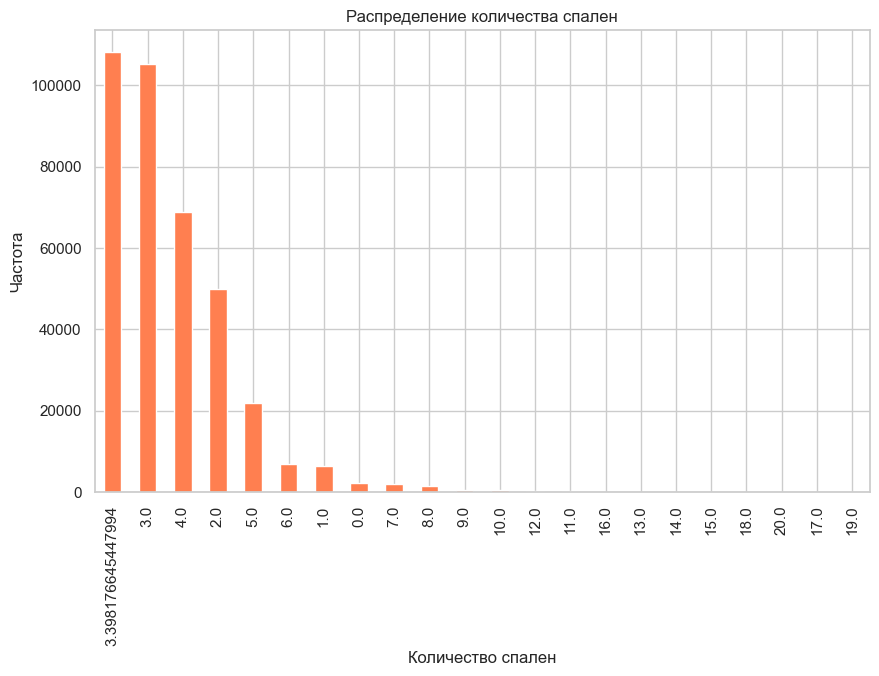

In [53]:
# Выводим уникальные значения и их количество
beds_counts = data['beds'].value_counts()
beds_counts
# Определяем порог для аномальных значений
beds_outliers_threshold = 20

# Выбираем значения, которые не являются аномалиями
filtered_beds = beds_counts[beds_counts.index <= beds_outliers_threshold]

# Строим график
plt.figure(figsize=(10, 6))
filtered_beds.plot(kind='bar', color='coral')
plt.title('Распределение количества спален')
plt.xlabel('Количество спален')
plt.ylabel('Частота')
plt.show()

In [54]:
# Рассчитываем верхний и нижний квантили
lower_quantile = data['beds'].quantile(0.05)
upper_quantile = data['beds'].quantile(0.95)

# Заменяем значения, выходящие за пределы квантилей, медианой
data['beds'] = np.where((data['beds'] < lower_quantile) | (data['beds'] > upper_quantile),
                        data['beds'].median(), data['beds'])

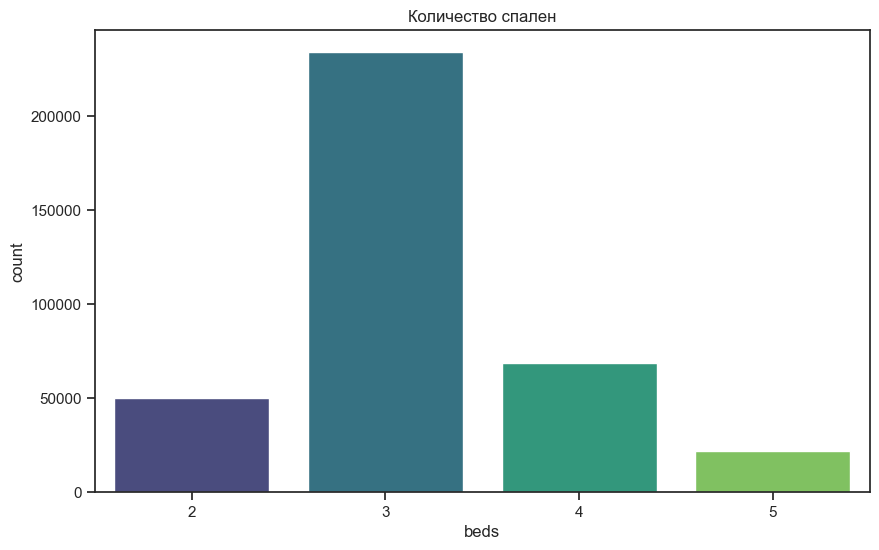

In [61]:
# Преобразуем столбец 'beds' в целочисленный формат
data['beds'] = data['beds'].astype(int)

# Установим стиль seaborn для более красочных графиков
sns.set(style="ticks")

# Строим график с измененной цветовой схемой
plt.figure(figsize=(10, 6))
sns.countplot(x=data['beds'], palette='viridis')  # Вы можете выбрать любую цветовую схему из доступных
plt.title('Количество спален')
plt.show()


Распределение количества спален (beds) в основном сосредоточено вокруг значений 2-5, что типично для недвижимости.
Значения, встречающиеся реже 20 раз, были заменены медианным значением. Это позволяет избежать слишком редких категорий, которые могли бы повлиять на модель.
Обработка пропущенных значений и выбросов также проведена.


### Обработка признака 'city'

In [62]:
# Уникальные значения признака
unique_city= data['city'].unique()

print(unique_city)

['Southern Pines' 'Spokane Valley' 'Los Angeles' ... 'Bedford Hts'
 'HAINES CITY' 'Blue Springs']


In [63]:
# Количество уникальных значений
data['city'].value_counts()

city
Houston         24406
San Antonio     15501
Miami           15411
Jacksonville     9892
Dallas           8770
                ...  
Lake worth          1
Lisle               1
Arrington           1
Santa Fe            1
Blue Springs        1
Name: count, Length: 2019, dtype: int64

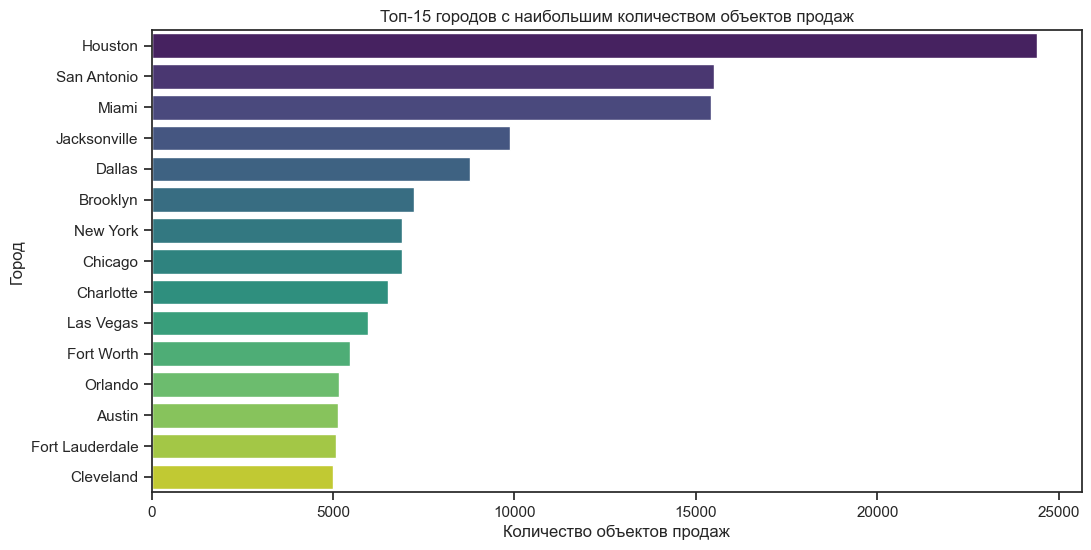

In [64]:
# Подготовка данных
city_counts = data['city'].value_counts()

# Отберем топ-N городов (например, топ-10)
top_cities = city_counts.head(15)

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")
plt.title('Топ-15 городов с наибольшим количеством объектов продаж')
plt.xlabel('Количество объектов продаж')
plt.ylabel('Город')
plt.show()

1. Houston, San Antonio и Miami лидируют по количеству объектов продаж. В этих городах представлено значительно больше объектов недвижимости по сравнению с другими городами.
2. Наблюдается существенное разнообразие в количестве объектов продаж в разных городах. Это может быть связано с различиями в рынках недвижимости, экономической активностью и другими факторами.
3. Разница в количестве объектов продаж между городами достаточно велика. Это может быть важным фактором при анализе рынка недвижимости и принятии решений о стратегии продаж или инвестирования.

In [65]:
# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Применяем LabelEncoder к признаку 'city'
data['city_encoded'] = label_encoder.fit_transform(data['city'])

In [66]:
# Удаляем признак 'сity' из датасета
data.drop('city', axis=1, inplace=True)

In [67]:
data.head()

,status,propertyType,baths,homeFacts,schools,sqft,beds,state,stories,target,city_encoded
0,Active,Single family,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,4,NC,Unknown,"$418,000",1705
1,Active,Single family,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","[{'rating': ['4/10', 'None/10', '4/10'], 'data...",948.0,3,WA,Low Rise (1-3 Stories),"$310,000",1715
2,Active,Single family,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...","[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3.0,3,CA,Low Rise (1-3 Stories),"$2,895,000",1031
3,Active,Single family,2.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...","[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",463.0,5,TX,Low Rise (1-3 Stories),"$2,395,000",430
4,Active,Land,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...","[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,3,FL,Unknown,"$5,000",1341


Категориальный признак 'city' успешно преобразован в числовой формат с использованием LabelEncoder.
Создан новый столбец 'city_encoded', содержащий числовые коды для каждого уникального города.
Исходный столбец 'city' удален из данных.
Это позволит использовать информацию о городе в моделях машинного обучения, которые требуют числовые входные данные.

### Обработка признака 'state'

In [68]:
# Уникальные значения признака 
unique_state= data['state'].unique()

print(unique_state)

['NC' 'WA' 'CA' 'TX' 'FL' 'PA' 'TN' 'IA' 'NY' 'OR' 'DC' 'NV' 'AZ' 'GA'
 'IL' 'NJ' 'MA' 'OH' 'IN' 'UT' 'MI' 'VT' 'MD' 'CO' 'VA' 'KY' 'MO' 'WI'
 'ME' 'MS' 'OK' 'SC' 'MT' 'DE' 'Fl' 'BA' 'AL' 'OT' 'OS']


In [69]:
# Количество уникальный значений
data['state'].value_counts()

state
FL    114627
TX     83345
NY     24335
CA     23207
NC     21778
TN     18230
WA     13733
OH     12431
IL      8851
NV      8421
GA      6637
CO      6377
PA      5510
MI      5126
DC      4584
AZ      3347
IN      3293
OR      2778
MA      1497
UT      1321
MD      1086
VT       864
MO       832
VA       800
WI       452
NJ       436
ME       258
IA       242
KY        90
OK        49
MS        39
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: count, dtype: int64

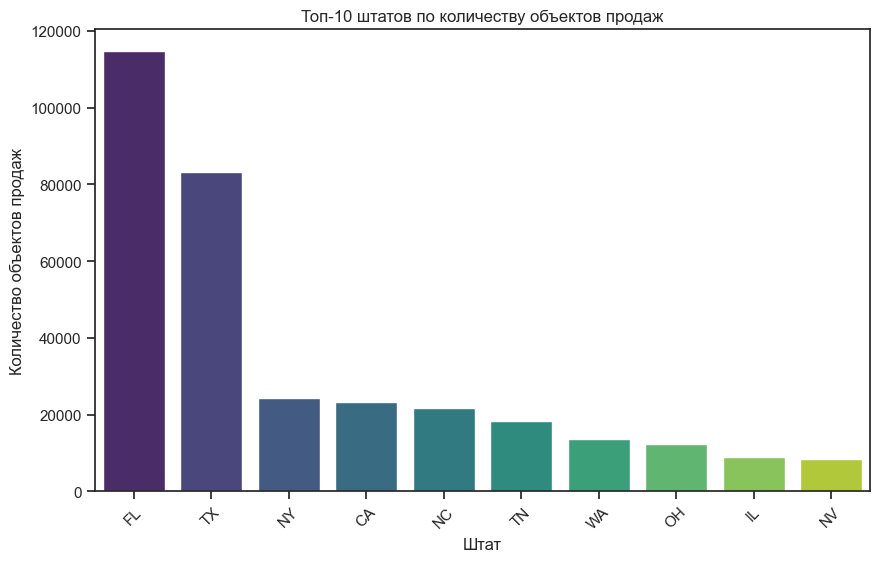

In [70]:
# Подготовим данные для графика
state_counts = data['state'].value_counts()

# Отобразим топ-10 штатов
top_states = state_counts.head(10)

# Построим график
plt.figure(figsize=(10, 6))
sns.barplot(x=top_states.index, y=top_states.values, palette='viridis')
plt.title('Топ-10 штатов по количеству объектов продаж')
plt.xlabel('Штат')
plt.ylabel('Количество объектов продаж')
plt.xticks(rotation=45)
plt.show()

In [71]:
# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

# Преобразуем признак 'state' в числовые значения
data['state_encoded'] = label_encoder.fit_transform(data['state'])

In [72]:
# Удаляем признак 'state' из датасета
data.drop('state', axis=1, inplace=True)

In [73]:
data.head()

,status,propertyType,baths,homeFacts,schools,sqft,beds,stories,target,city_encoded,state_encoded
0,Active,Single family,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,4,Unknown,"$418,000",1705,21
1,Active,Single family,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","[{'rating': ['4/10', 'None/10', '4/10'], 'data...",948.0,3,Low Rise (1-3 Stories),"$310,000",1715,37
2,Active,Single family,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...","[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3.0,3,Low Rise (1-3 Stories),"$2,895,000",1031,3
3,Active,Single family,2.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...","[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",463.0,5,Low Rise (1-3 Stories),"$2,395,000",430,33
4,Active,Land,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...","[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,3,Unknown,"$5,000",1341,7


Категориальный признак 'state' был успешно преобразован в числовой формат с использованием LabelEncoder.
Создан новый столбец 'state_encoded', содержащий числовые коды для каждого уникального штата.
Этот подход обеспечивает удобство работы с алгоритмами машинного обучения, которые требуют числовых значений.

### Обработка целевого признака 'target'

In [74]:
# Уникальные значения целевого признака 
unique_targets = data['target'].unique()

print(unique_targets)

['$418,000' '$310,000' '$2,895,000' ... '$815,881' '342,969' '$171,306']


In [75]:
# Количество уникальный значений
data['target'].value_counts()

target
$225,000      1462
$275,000      1355
$250,000      1312
$350,000      1296
$299,900      1276
              ... 
$1,799,219       1
$112,400         1
$497,331         1
$303,017         1
$171,306         1
Name: count, Length: 43937, dtype: int64

In [76]:
# Удаляем символы доллара, запятых и других лишних символов
data['target'] = data['target'].replace('[\$,+]', '', regex=True)

# Преобразуем в числа
data['target'] = pd.to_numeric(data['target'], errors='coerce')

# Применяем логарифмическое преобразование
data['target_log'] = np.log1p(data['target'])

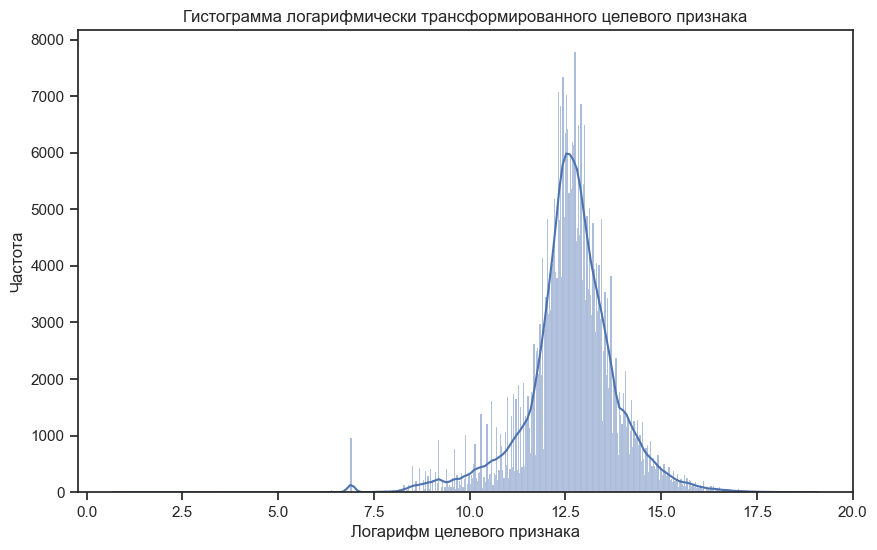

In [77]:
# Строим гистограмму с Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data['target_log'], kde=True)
plt.title('Гистограмма логарифмически трансформированного целевого признака')
plt.xlabel('Логарифм целевого признака')
plt.ylabel('Частота')
plt.show()

In [78]:
# Вычисляем межквартильное расстояние
Q1 = data['target_log'].quantile(0.25)
Q3 = data['target_log'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
outliers = data[(data['target_log'] < lower_bound) | (data['target_log'] > upper_bound)]

print('Количество выбросов:', len(outliers))
print('Границы выбросов:', lower_bound, upper_bound)

Количество выбросов: 26179
Границы выбросов: 10.441405612282752 14.980778665841202


In [79]:
# Удаляем строки, содержащие пропущенные значения
data = data.dropna(subset=['target', 'target_log'])

In [80]:
# Удаляем признак target
data.drop('target', axis=1, inplace=True)

# Переименуем target_log как target
data.rename(columns={'target_log': 'target'}, inplace=True)

Преобразование целевого признака 'target' в логарифмическую шкалу может быть полезным для сглаживания распределения, особенно если у есть выбросы или данные с необычно большим разбросом.
Были удалены символы доллара и запятые, а затем применено логарифмическое преобразование.

### Обработка признака 'homeFacts'

In [81]:
# Изучим признак 'homeFacts'
data['homeFacts'].head()

0    {'atAGlanceFacts': [{'factValue': '2019', 'fac...
1    {'atAGlanceFacts': [{'factValue': '2019', 'fac...
2    {'atAGlanceFacts': [{'factValue': '1961', 'fac...
3    {'atAGlanceFacts': [{'factValue': '2006', 'fac...
4    {'atAGlanceFacts': [{'factValue': '', 'factLab...
Name: homeFacts, dtype: object

In [82]:
# Уникальные значения признака
unique_homefacts= data['homeFacts'].unique()

print(unique_homefacts)

["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"
 "{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}"
 "{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factLab

In [83]:
# Количество уникальных значений
#data['homeFacts'].value_counts()

In [84]:
# Извлекаем информацию с фактами о доме и создаем новые столбцы с этой информацией
def extract_home_facts(facts_string):
    try:
        facts_dict = ast.literal_eval(facts_string)
        atAGlanceFacts = facts_dict.get('atAGlanceFacts', [])

        year_built = next((item['factValue'] for item in atAGlanceFacts if item['factLabel'] == 'Year built'), None)
        remodeled_year = next((item['factValue'] for item in atAGlanceFacts if item['factLabel'] == 'Remodeled year'), None)
        heating = next((item['factValue'] for item in atAGlanceFacts if item['factLabel'] == 'Heating'), None)
        cooling = next((item['factValue'] for item in atAGlanceFacts if item['factLabel'] == 'Cooling'), None)
        parking = next((item['factValue'] for item in atAGlanceFacts if item['factLabel'] == 'Parking'), None)
        lot_size = next((item['factValue'] for item in atAGlanceFacts if item['factLabel'] == 'lotsize'), None)
        price_per_sqft = next((item['factValue'] for item in atAGlanceFacts if item['factLabel'] == 'Price/sqft'), None)

        return year_built, remodeled_year, heating, cooling, parking, lot_size, price_per_sqft
    except Exception as e:
        print(f"Error processing homeFacts: {e}")
        return None, None, None, None, None, None, None

# Применим функцию к столбцу 'homeFacts' и создадим новые столбцы
data[['year_built', 'remodeled_year', 'heating', 'cooling', 'parking', 'lot_size', 'price_per_sqft']] = data['homeFacts'].apply(lambda x: pd.Series(extract_home_facts(x)))

In [85]:
data.head(3)

,status,propertyType,baths,homeFacts,schools,sqft,beds,stories,city_encoded,state_encoded,target,year_built,remodeled_year,heating,cooling,parking,lot_size,price_per_sqft
0,Active,Single family,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,4,Unknown,1705,21,12.943239,2019,,"Central A/C, Heat Pump",,,None,$144
1,Active,Single family,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","[{'rating': ['4/10', 'None/10', '4/10'], 'data...",948.0,3,Low Rise (1-3 Stories),1715,37,12.644331,2019,,,,,5828 sqft,$159/sqft
2,Active,Single family,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...","[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3.0,3,Low Rise (1-3 Stories),1031,3,14.878496,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft


In [86]:
# Удаляем признак 'homeFacts' из датасета
data = data.drop(['homeFacts'], axis=1)

После обработки признака 'homeFacts', были созданы несколько новых числовых признаков, таких как 'year_built', 'remodeled_year', 'price_per_sqft', а также категориальные признаки, такие как 'heating', 'cooling', 'parking', 'lot_size'.

Информация о теплоснабжении, охлаждении, парковке и размере участка была успешно извлечена и добавлена в отдельные столбцы.
Эти категориальные данные могут быть использованы для анализа и построения моделей.

Также была извлечена информация о цене за квадратный фут и создан новый признак 'price_per_sqft'.

В целом, обработка признака 'homeFacts' позволила создать новые признаки, которые могут быть полезны при анализе данных и построении моделей. Однако, необходимо обратить внимание на аномалии и продолжить анализ для улучшения качества данных.

### Признак 'year_built'

In [87]:
# Уникальные значения признака
unique_year_built= data['year_built'].unique()

print(unique_year_built)

['2019' '1961' '2006' '' '1920' '1976' '1970' '1965' '2015' '1996' '1982'
 '1905' '2008' '1899' '2016' '1954' '1989' '2014' '1915' '1994' '1910'
 '1923' '1960' '1977' '1972' '1963' '1981' '1949' '1930' '1991' '1958'
 '2005' '2017' '2018' '1983' '1928' '1998' '1997' '1964' '1974' '1940'
 '1973' '1968' '1999' '1918' '2007' '1984' '1946' '2003' '2000' '2004'
 '1969' '2002' '1952' '1947' '1957' '1978' '1956' '1967' '1975' '1988'
 '1955' '1950' '1959' '2012' '1924' '1966' '1992' '2001' '1995' '2010'
 '1971' '1909' '1953' '1993' '1990' '1980' '1985' '1951' '1907' '1885'
 '1941' '1927' '1929' '1901' None '1922' '1906' '1945' '1979' '2009'
 '1962' '1913' '2011' '1897' '1987' '2020' '1926' '1939' '1925' '2013'
 '1986' 'No Data' '1943' '1935' '1890' '1895' '1911' '1948' '1942' '1916'
 '1900' '1931' '1944' '1893' '1879' '1914' '1937' '1912' '1938' '1921'
 '1860' '1850' '1936' '1861' '1898' '1908' '1865' '1917' '1740' '1934'
 '1902' '1880' '1700' '1904' '1932' '1896' '1892' '1830' '1919' '1933'
 '

In [88]:
# Количество уникальных значений
data['year_built'].value_counts()

year_built
        58452
2019    32132
2006     7945
2005     7444
2007     7080
        ...  
1740        1
1845        1
1208        1
1823        1
1804        1
Name: count, Length: 228, dtype: int64

In [89]:
# Заменяем 'No Data' на NaN
data['year_built'] = data['year_built'].replace('No Data', np.nan)

# Заменяем артефакты на NaN
data['year_built'] = pd.to_numeric(data['year_built'], errors='coerce')

# Отфильтруем годы в пределах разумного диапазона
data = data[(data['year_built'] > 1800) & (data['year_built'] < 2023)]

# Заполним пропущенные значения медианным значением
data['year_built'].fillna(data['year_built'].median(), inplace=True)

# Преобразуем столбец в целочисленный формат
data['year_built'] = data['year_built'].astype(int)

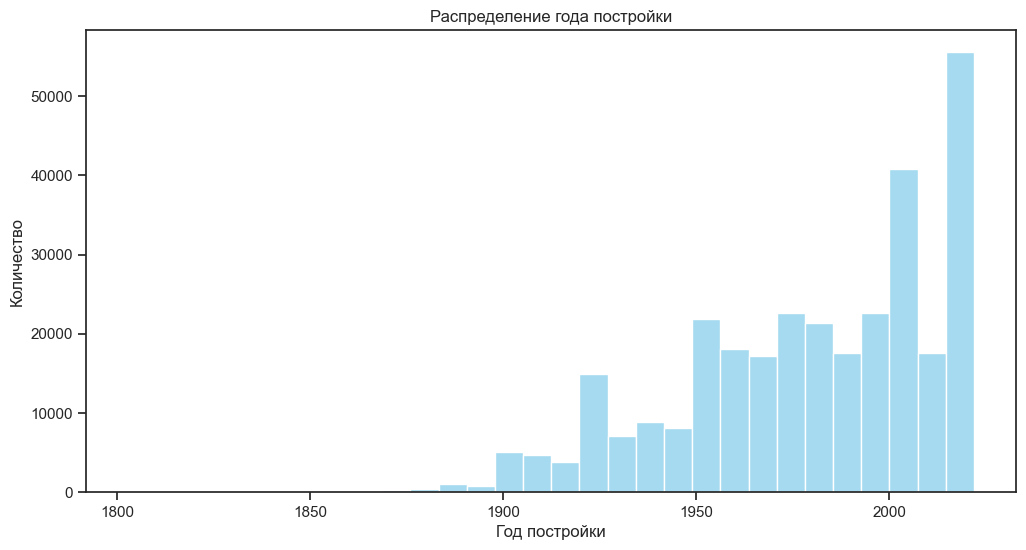

In [90]:
# Отфильтруем аномалии
filtered_data = data[(data['year_built'] > 1800) & (data['year_built'] < 2023)]

# Построим гистограмму
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['year_built'], bins=30, kde=False, color='skyblue')
plt.title('Распределение года постройки')
plt.xlabel('Год постройки')
plt.ylabel('Количество')
plt.show()

Большинство объектов недвижимости сосредоточены в последние десятилетия, но также есть старые постройки.
Распределение имеет несколько пиков, что может указывать на разные периоды строительства, в том числе возможные реставрации или реконструкции. Обработка признака позволяет использовать его в анализе данных и построении модели.


### Признак 'remodeled_year'

In [91]:
# Уникальные значения признака 
unique_remodeled_year= data['remodeled_year'].unique()

print(unique_remodeled_year)

['' '1967' '2006' None '2015' '1997' '2019' '1982' '1905' '2009' '2007'
 '1996' '1995' '1988' '1972' '1949' '1954' '1930' '2000' '1994' '2005'
 '1983' '2003' '1965' '1968' '1993' '1999' '2014' '2008' '2010' '2004'
 '2002' '1952' '1978' '1975' '1971' '1947' '1957' '1950' '1973' '1970'
 '2016' '1989' '1998' '1980' '1955' '1991' '2011' '2017' '1986' '1941'
 '2001' '1990' '1979' '1901' '1984' '1918' '1977' '1962' '1956' '2013'
 '1960' '1981' '1969' '1987' '1958' '1925' '1964' '1966' '1992' '1943'
 '1961' '1948' '1931' '2012' '1976' '1974' '1935' '1910' '1940' '2018'
 '1916' '1914' '1963' '1985' '1951' '1942' '1959' '1927' '1946' '1944'
 '1945' '1920' '1938' '1936' '0' '1939' '1915' '1928' '1923' '1929' '1898'
 '1899' '1934' '1953' '1926' '1937' '1912' '1917' '1906' '1932' '1919'
 '1921' '1924' '1907' '1911' '1900' '1913' '1895' '1908' '1903' '1904'
 '1933' '1894' '1892' '1922' '1909' '1880' '1902' '1877' '1893' '1890'
 '2020' '1891' '1889' '1884' '1897' '1886' '1846' '1896' '1885' '1870'
 

In [92]:
# Количество уникальных значений
data['remodeled_year'].value_counts()

remodeled_year
        140960
2006      5478
2005      4746
2007      4325
2008      3738
         ...  
1870         1
1853         1
1888         1
1738         1
1862         1
Name: count, Length: 149, dtype: int64

In [93]:
# Преобразуем признак в числовой формат, заменяя недопустимые значения на NaN
data['remodeled_year'] = pd.to_numeric(data['remodeled_year'], errors='coerce')

# Заменяем пропущенные значения медианой
median_remodeled_year = data['remodeled_year'].median()
data['remodeled_year'].fillna(median_remodeled_year, inplace=True)

# Создаем бинарный признак 'was_remodeled'
data['was_remodeled'] = (data['remodeled_year'] > 0).astype(int)

# Выводим новый признак
print(data[['was_remodeled', 'remodeled_year']].head())

   was_remodeled  remodeled_year
0              1          1986.0
1              1          1986.0
2              1          1967.0
3              1          2006.0
5              1          1986.0


In [94]:
# Удаляем столбец 'remodeled_year'
data = data.drop(['remodeled_year'], axis=1)

Пропущенные значения в признаке 'year_built' были заполнены медианным значением, а также были удалены аномальные значения и некорректные записи.
Из признака 'homeFacts' извлечены необходимые числовые значения, такие как год постройки, год реконструкции и другие характеристики.
Создан новый признак - 'was_remodeled', отражающий факт наличия или отсутствия ремонта.

Визуализированы некоторые распределения с использованием гистограммы для признаков 'year_built'.
Обработка данных позволила сделать датасет более пригодным для дальнейшего анализа и построения моделей машинного обучения.

### Признак 'heating'

In [95]:
# Уникальные значения признака 'heating''
unique_heating = data['heating'].unique()

print(unique_heating)

['Central A/C, Heat Pump' '' 'Forced Air' ...
 'Electric Furnace, Electric Heat Pump'
 'Floor Furnace, Wall Electric, Wall Gas'
 'Baseboard, Hot Water, Programmable Thermostat, Radiant Floor']


In [96]:
# Количество уникальных значений
data['heating'].value_counts()

heating
Forced Air                                                      81210
                                                                53003
Forced air                                                      50681
Other                                                           28832
Central Air                                                      7801
                                                                ...  
BR Closet-Electric - new                                            1
Wood Stove                                                          1
Electric, Oil, Propane                                              1
Electric, Exhaust Fans, Heat Pump                                   1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor        1
Name: count, Length: 1958, dtype: int64

In [97]:
# Очистка и категоризация данных
def clean_and_categorize_heating(heating_series):
    # Словари для замены значений 'heating'
    heating_dict = {
        'No Data': np.nan,
        'None': '0',
        'No Heating': '0',
        'No Heat': '0',
        'No Heat System': '0'
    }

    # Регулярные выражения для замены значений 'heating'
    reg_heating = {
        'ceiling fan:1 master/1 lr': 'ceiling fan',
        'ceiling fan\(s\)': 'ceiling fan',
        'cool-ceiling fan': 'ceiling fan',
        'forcedair': 'forced air',
        'paddle fans': 'ceiling fan',
        'ac (central)': 'cental a/c',
        'no heat fuel': '0',
        '^, ': ''
    }

    # Заменяем значения 'heating' с использованием словарей и регулярных выражений
    cleaned_heating = heating_series.replace(heating_dict).str.lower().replace(reg_heating, regex=True)

    # Разделяем значения 'heating' на отдельные строки
    split_heating = cleaned_heating.apply(lambda x: re.split(r',\s?', x) if isinstance(x, str) else None)

    # Посчитаем количество уникальных значений после разделения
    split_heating_list = split_heating.explode().value_counts()

    # Выводим результатов
    print(split_heating_list)

    # Категории для замены значений 'heating'
    heating_categories = {
        'forced air': 'forced_air_heating',
        'ceiling fan': 'ceiling_fan_heating',
        'cental a/c': 'central_air_heating',
        '0': 'no_heating', 
        '': 'unknown_heating'
    }

    # Заменяем значения в соответствии с категориями
    categorized_heating = cleaned_heating.replace(heating_categories)

    # Выводим уникальные значений после категоризации
    unique_heating_categories = categorized_heating.unique()
    print(unique_heating_categories)

    return categorized_heating

# Применяем функции к столбцу 'heating'
data['heating'] = clean_and_categorize_heating(data['heating'])


heating
forced air                       137094
                                  53006
other                             29350
electric                          13593
central                           12630
                                  ...  
mud room-electric                     1
main floor closet-tankless            1
next to washer/dryer-electric         1
wood burn stove                       1
closet outside bath-on demand         1
Name: count, Length: 678, dtype: int64
['central a/c, heat pump' 'unknown_heating' 'forced_air_heating' ...
 'electric furnace, electric heat pump'
 'floor furnace, wall electric, wall gas'
 'baseboard, hot water, programmable thermostat, radiant floor']


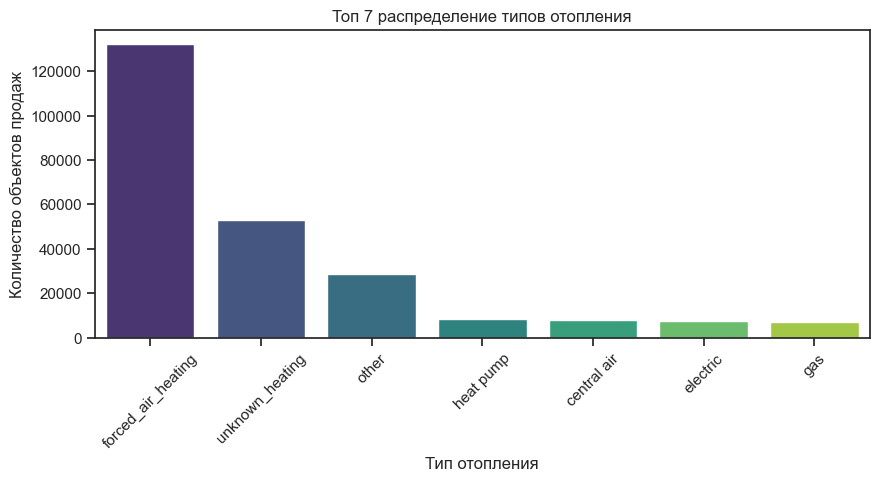

In [98]:
# Подготовим данные для графика
heating_counts = data['heating'].value_counts()

# Выбираем топ 7 видов отопления
top_heating_counts = heating_counts.head(7)

# Построим график
plt.figure(figsize=(10, 4))
sns.barplot(x=top_heating_counts.index, y=top_heating_counts.values, palette='viridis')
plt.title('Топ 7 распределение типов отопления')
plt.xlabel('Тип отопления')
plt.ylabel('Количество объектов продаж')
plt.xticks(rotation=45)
plt.show()

Forced Air Heating - преобладающий тип отопления среди объектов продаж. Это может указывать на популярность этого вида отопления в рассматриваемой области.
Unknown Heating - существенная часть данных не имеет явного указания типа отопления. Это может быть связано с отсутствием информации в объявлениях или разнообразием способов отопления, которые не укладываются в стандартные категории.
Electric Heating - электрическое отопление также представлено в данных, но его доля заметно меньше, чем у принудительной вентиляции (Forced Air).
Central Air Heating - тип отопления, связанный с центральным кондиционированием воздуха, также присутствует, но с меньшей частотой по сравнению с принудительной вентиляцией.

Значения 'heating' были очищены и категоризованы.
В результате разделения значений на отдельные строки были обнаружены различные варианты записи тех же категорий (например, 'Forced air' и 'forcedair').
Уникальные значения 'heating' были приведены к категориям, таким как 'forced_air_heating', 'ceiling_fan_heating', 'central_air_heating', 'no_heating', 'unknown_heating'.
После категоризации видно, что наиболее распространенным типом отопления является 'forced air' (137,094 записей), также есть категории 'other' (29,350 записей), 'electric' (13,593 записей), и другие.
Некоторые значения были признаны как 'unknown_heating' из-за отсутствия явной информации о типе отопления.
Общее количество уникальных категорий сократилось до 678 после очистки и категоризации.

### Признак 'cooling'

In [99]:
# Уникальные значения признака 
unique_cooling = data['cooling'].unique()

print(unique_cooling)

['' 'Central' 'Central Air' ...
 'Central Air, Electric Hot Air, Gas (Hot Air), Heat Pump for A/C, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat, Natural Gas'
 '90%+ High Efficiency, Ductless HP-Mini Split, Tankless Water Heater'
 'Central A/C (Gas), Central Heat (Gas), Heat Pump']


In [100]:
# Количество уникальных значений 
data['cooling'].value_counts()

cooling
Central                                                                               155238
                                                                                       62891
Central Air                                                                            14361
Has Cooling                                                                             9716
No Data                                                                                 9655
                                                                                       ...  
Other,                                                                                     1
Central Air, Gas (Hot Air), Window Unit                                                    1
Air Conditioning-Room, Evaporative Cooler (Swamp)                                          1
Central Air, Electric Hot Air, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat         1
Central A/C (Gas), Central Heat (Gas), Heat Pump              

In [101]:
# Функция для очистки и категоризации данных в столбце 'cooling'
def clean_and_categorize_cooling(cooling_series):
    # Словари для замены значений 'cooling'
    cool_dict = {
        'No Data': np.nan,
        'None': '0',
        'No A/C': '0',
        'Other, None': '0',
        'No A/C, Other (See Remarks)': '0'
    }

    # Регулярные выражения для замены значений 'cooling'
    cool_reg = {
        'ceiling fan\(s\)': 'ceiling fan',
        'central a\/c \(electric\)': 'central a/c, central electric',
        'fans \- ceiling': 'ceiling fan',
        'fans ceiling paddle': 'ceiling fan',
        'paddle fans': 'ceiling fan',
        'central air': 'central a/c',
        'air conditioning\-central': 'central a/c',
        'zoned cooling': 'zoned',
        'multi\-zone cooling': 'multizone',
        'multi\-zone': 'multizone',
        'multi\-zone a\/c': 'multizone a/c',
        'multi zone': 'multizone',
        'multi\/zone cooling': 'multizone',
        'zoned air cond': 'zoned a/c',
        'multizoned': 'multizone',
        'none': '0',
        'no cooling/vent': '0',
        'no a/c': '0',
        'no air conditioning': '0',
        'central ac': 'central a/c',
        'cenrtal ac': 'central a/c',
        'central cooling': 'central a/c',
        'ceiling fans': 'ceiling fan',
        'whole house fan': 'ceiling fan',
        'whole house \/ attic fan': 'ceiling fan',
        'attic fan': 'ceiling fan',
        'attic fan\(s\)': 'ceiling fan',
        'fans \- attic': 'ceiling fan',
        'attic ventilator': 'ceiling fan',
        'fan attic': 'ceiling fan',
        'zoned': 'zone',
        'no data, forced air': 'forced air'
    }

    # Заменяем значения 'cooling' с использованием словарей и регулярных выражений
    cleaned_cooling = cooling_series.replace(cool_dict).str.lower().replace(cool_reg, regex=True)

    # Разделение значений 'cooling' на отдельные строки
    split_cooling = cleaned_cooling.apply(lambda x: re.split(r',\s?', x) if isinstance(x, str) else None)

    # Посчитаем количество уникальных значений после разделения
    split_cooling_list = split_cooling.explode().value_counts()

    # Выводим результат
    print(split_cooling_list)

    # Категории для замены значений 'cooling'
    cooling_categories = {
        'central': 'central_air',
        'central a/c': 'central_air',
        'ceiling fan': 'ceiling_fan',
        'no cooling': 'no_cooling',
        'has cooling': 'other_cooling',
        'central electric': 'central_air',
        'forced air': 'forced_air',
        'zoned': 'zoned_cooling',
        'multi-zone': 'multizone_cooling',
        'evaporative': 'evaporative_cooling',
        'window unit': 'window_unit',
        'heat pump': 'heat_pump_cooling',
        'wall unit': 'wall_unit',
        'ductless mini-split': 'ductless_mini_split',
        'other': 'other_cooling',  
        'unknown': 'other_cooling',
    }

    # Заменяем значения в соответствии с категориями
    categorized_cooling = cleaned_cooling.replace(cooling_categories)

    # Выводим уникальные значения после категоризации
    unique_cooling_categories = categorized_cooling.unique()
    print(unique_cooling_categories)

    return categorized_cooling


# Заменяем все "пустые" значения на 'unknown_cooling'
data['cooling'] = data['cooling'].replace('', 'unknown_cooling')

# Переименовываем значения с использованием функции clean_and_categorize_cooling
data['cooling'] = clean_and_categorize_cooling(data['cooling'])

cooling
central                  158676
unknown_cooling           62891
central a/c               26230
central electric          11832
has cooling                9716
                          ...  
baseboard - cast iron         1
multiunits                    1
mini-split                    1
oil                           1
central a/c/refrig            1
Name: count, Length: 280, dtype: int64
['unknown_cooling' 'central_air' 'central gas' ...
 'central a/c, electric hot air, gas (hot air), heat pump for a/c, heat pump for heat, multizone a/c, multizone heat, natural gas'
 '90%+ high efficiency, ductless hp-mini split, tankless water heater'
 'central a/c (gas), central heat (gas), heat pump']


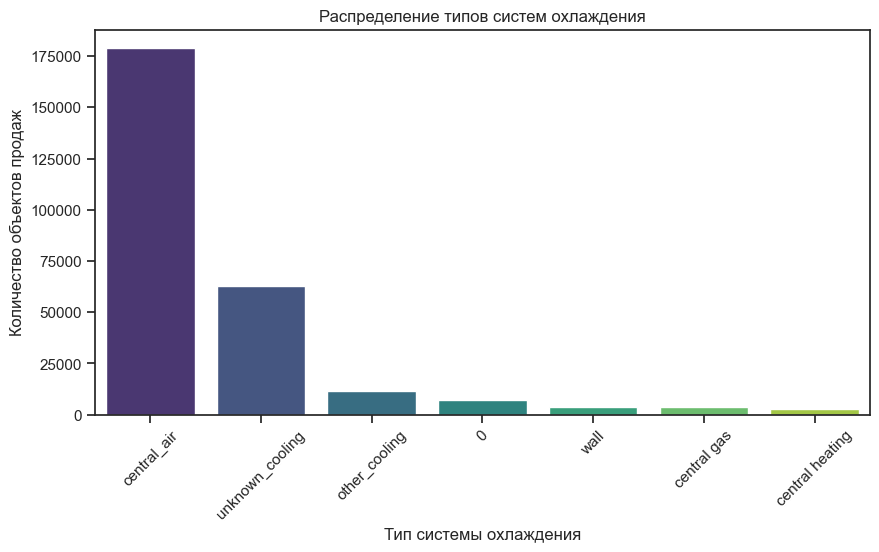

In [102]:
# Подготовим данные для графика
cooling_counts = data['cooling'].value_counts().head(7)

# Построим график
plt.figure(figsize=(10, 5))
sns.barplot(x=cooling_counts.index, y=cooling_counts.values, palette='viridis')
plt.title('Распределение типов систем охлаждения')
plt.xlabel('Тип системы охлаждения')
plt.ylabel('Количество объектов продаж')
plt.xticks(rotation=45)
plt.show()

Центральные системы охлаждения (Central Air): Преобладающий тип систем охлаждения среди объектов продаж.
Отсутствие данных (Unknown): Значительное количество объектов имеют неопределенный тип системы охлаждения, что может быть вызвано неполной информацией или разнообразием вариантов.
Системы охлаждения "Ceiling Fan" (Вентиляторы на потолке): Этот тип системы охлаждения также встречается в значительном количестве объектов, что может указывать на популярность вентиляторов на потолке в некоторых регионах.
Другие типы систем охлаждения: В графике видны и другие типы систем охлаждения, такие как "Forced Air", "Zoned Cooling", "Heat Pump Cooling" и другие.
Разнообразие вариантов: Рынок предлагает разнообразие систем охлаждения, что может быть связано с климатическими особенностями различных регионов.

Обработка признака 'cooling' позволила более точно категоризировать данные, учесть разнообразие вариантов охлаждения, а также решить вопрос с пропущенными значениями.

### Признак 'parking'

In [103]:
# Уникальные значения признака 
unique_parking = data['parking'].unique()

print(unique_parking)

['' 'Attached Garage' 'Detached Garage' ... 'Basement, Detached'
 'Paved Driveway, Off Street, Detached Garage'
 'Deed Restrictions, Fitness, Gated Community, Golf Carts OK, No Truck/RV/Motorcycle Parking, Pool, Special Community Restrictions']


In [104]:
# Количество уникальных значений
data['parking'].value_counts()

parking
                                                                                                                                    114431
Attached Garage                                                                                                                      68838
2 spaces                                                                                                                             27223
1 space                                                                                                                              14029
Detached Garage                                                                                                                      13007
                                                                                                                                     ...  
Boat, Driveway, Garage Door Opener, Garage Faces Rear, Oversized, Workshop in Garage                                                     1
Assigned, Open, Und

In [105]:
# Приведем значения к нижнему регистру и удалим возможные пробелы в начале и конце строк
data['parking'] = data['parking'].str.lower().str.strip()

# Заменим значения 'no data' и пропущенные значения на 'unknown'
data['parking'].replace({'no data': 'unknown', np.nan: 'unknown'}, inplace=True)

In [106]:
# Уникальные значения после обработки признака
data['parking'].unique

<bound method Series.unique of 0                        
1                        
2         attached garage
3         detached garage
5                        
               ...       
377179            1 space
377180           2 spaces
377181               none
377182                  2
377184            unknown
Name: parking, Length: 310966, dtype: object>

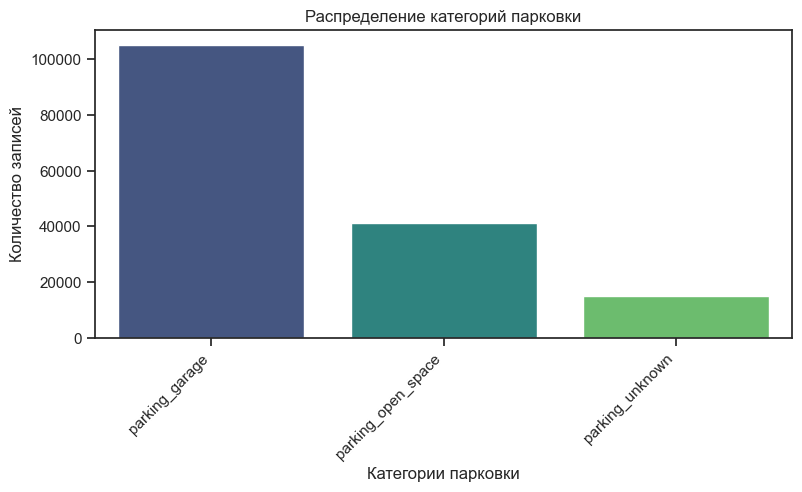

In [107]:
# Обновляем словарь для группировки
parking_mapping = {
    'garage': ['attached garage', 'detached garage', 'carport', 'garage'],
    'open_space': ['2 spaces', '1 space'],
    'unknown': ['no data', 'none', 'unknown'],
}

# Группируем признаки
for category, values in parking_mapping.items():
    data['parking_' + category] = data['parking'].apply(lambda x: 1 if any(value in x for value in values) else 0)

# Включаем категорию 'unknown'
data['parking_unknown'] = data['parking'].apply(lambda x: 1 if any(value in x for value in parking_mapping['unknown']) else 0)

# Построим график
plt.figure(figsize=(9, 4))
parking_categories = data.filter(like='parking_').columns
parking_counts = data[parking_categories].sum()
sns.barplot(x=parking_counts.index, y=parking_counts.values, palette="viridis")
plt.title('Распределение категорий парковки')
plt.xlabel('Категории парковки')
plt.ylabel('Количество записей')
plt.xticks(rotation=45, ha="right")
plt.show()

После предобработки признака 'parking' удалены пробелы и приведены значения к нижнему регистру.
Значения 'no data' и пропущенные значения заменены на 'unknown'.
Созданы отдельные категории для группировки различных типов парковок (гаражи, открытая площадка, неизвестно).
По графику распределения видно, что большинство объектов имеют открытые парковочные места или гаражи, при этом есть часть данных с неизвестным типом парковки.
Итак, столбец 'parking' теперь содержит удобные категории для дальнейшего анализа, и большинство объектов имеют определенный тип парковки.

### Признак 'lot_size'

Признак 'lot_size', представляющий размер участка, содержит значительное количество пропущенных значений, и его влияние на целевую переменную не представляется критически важным для поставленной задачи. Эксперименты показали, что попытки заполнения пропусков в 'sqft' с использованием данных из 'lot_size' приводят к появлению выбросов, которые в свою очередь будут удалены при обработке целевой переменной. В связи с этим, решено удалить признак 'lot_size'.

In [108]:
# Удалим признак из датасета
data.drop('lot_size', axis=1, inplace=True)

### Обработка признака 'schools'

In [109]:
# Уникальные значения признака
unique_schools = data['schools'].unique()

print(unique_schools)

['[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'
 "[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]"
 "[{'rating': ['8/10', '4/10', '8/10'], 'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Paul Revere Middle School', 'Brentwood Science School

In [110]:
# Функция для извлечения среднего рейтинга школ из данных о школах
def extract_average_rating(schools_data):
    try:
        schools_data = eval(schools_data)  # Преобразуем строки в список словарей
        ratings = [school.get('rating', []) for school in schools_data]
        ratings = [int(r.split('/')[0]) for r in sum(ratings, []) if '/' in r and r.split('/')[0].isdigit()]
        return np.nanmean(ratings) if ratings else np.nan
    except (SyntaxError, TypeError, AttributeError):
        return np.nan

# Применим функции к столбцу 'schools' и создание нового признака 'average_rating'
data['average_rating'] = data['schools'].apply(extract_average_rating)

# Удалим признак 'schools'
data = data.drop('schools', axis=1)

In [111]:
# Посмотрим на количество пропусков в новом признаке 'average_rating'
missing_average_rating = data['average_rating'].isnull().sum()
total_records = len(data)

# Выведем процент пропусков
percentage_missing = (missing_average_rating / total_records) * 100
print(f"Пропуски в 'average_rating': {missing_average_rating} из {total_records} записей ({percentage_missing:.2f}%)")

Пропуски в 'average_rating': 92970 из 310966 записей (29.90%)


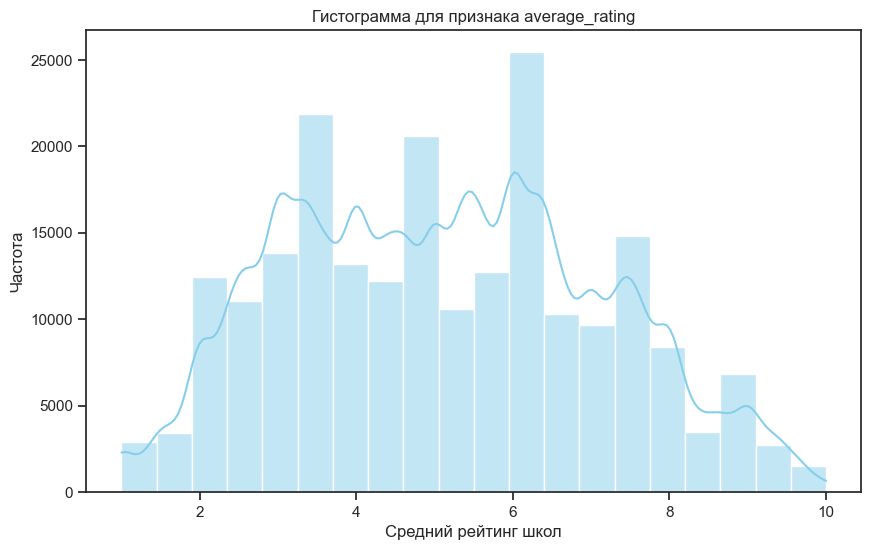

In [112]:
# Построим гистограмму для признака 'average_rating'
plt.figure(figsize=(10, 6))
sns.histplot(data['average_rating'], bins=20, kde=True, color='skyblue')
plt.title('Гистограмма для признака average_rating')
plt.xlabel('Средний рейтинг школ')
plt.ylabel('Частота')
plt.show()

In [113]:
# Рассчитаем интерквартильный диапазон (IQR) для 'average_rating'
Q1 = data['average_rating'].quantile(0.25)
Q3 = data['average_rating'].quantile(0.75)
IQR = Q3 - Q1

# Определим границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Посчитаем количество выбросов
outliers_count = ((data['average_rating'] < lower_bound) | (data['average_rating'] > upper_bound)).sum()

print(f"Количество выбросов в признаке 'average_rating': {outliers_count}")

Количество выбросов в признаке 'average_rating': 0


In [114]:
# Заполним пропуски в 'average_rating' средним значением
average_rating_mean = data['average_rating'].mean()
data['average_rating'].fillna(average_rating_mean, inplace=True)

In [115]:
data.head()

,status,propertyType,baths,sqft,beds,stories,city_encoded,state_encoded,target,year_built,heating,cooling,parking,price_per_sqft,was_remodeled,parking_garage,parking_open_space,parking_unknown,average_rating
0,Active,Single family,3.5,2900.0,4,Unknown,1705,21,12.943239,2019,"central a/c, heat pump",unknown_cooling,,$144,1,0,0,0,5.120708
1,Active,Single family,3.0,948.0,3,Low Rise (1-3 Stories),1715,37,12.644331,2019,unknown_heating,unknown_cooling,,$159/sqft,1,0,0,0,4.000000
2,Active,Single family,2.0,3.0,3,Low Rise (1-3 Stories),1031,3,14.878496,1961,forced_air_heating,central_air,attached garage,$965/sqft,1,1,0,0,6.666667
3,Active,Single family,2.0,463.0,5,Low Rise (1-3 Stories),430,33,14.688894,2006,forced_air_heating,central_air,detached garage,$371/sqft,1,1,0,0,9.250000
5,Active,Townhouse,2.0,897.0,2,Low Rise (1-3 Stories),1382,30,12.250094,1920,forced_air_heating,central_air,,$233/sqft,1,0,0,0,5.120708


### Обработка признака 'price_per_sqft'

In [116]:
# Уникальные значения признака
unique_price_per_sqft = data['price_per_sqft'].unique()

print(unique_price_per_sqft)

['$144' '$159/sqft' '$965/sqft' ... '$1141 / Sq. Ft.' '$2,592' '$2,032']


In [117]:
# Количество уникальных значений
data['price_per_sqft'].value_counts()

price_per_sqft
                 4217
No Data           929
$1/sqft           896
No Info           780
$125/sqft         677
                 ... 
$1,093/sqft         1
$1,417/sqft         1
$2,168              1
$389,000/sqft       1
$2,032              1
Name: count, Length: 6396, dtype: int64

In [118]:
# Удаляем символ '$' и текст '/ sq. ft.' из признака 'price_per_sqft'
data['price_per_sqft'] = data['price_per_sqft'].replace('[\$,]', '', regex=True)

# Преобразуем значения в числовой формат, игнорируя ошибки
data['price_per_sqft'] = pd.to_numeric(data['price_per_sqft'], errors='coerce')

# Заполним пропущенные значения средними значениями
data['price_per_sqft'] = data['price_per_sqft'].fillna(data['price_per_sqft'].mean())
data['price_per_sqft'].head()

0    144.000000
1    331.694524
2    331.694524
3    331.694524
5    331.694524
Name: price_per_sqft, dtype: float64

Обработка признака price_per_sqft позволила привести данные в числовой формат и заполнить пропущенные значения. Однако, из-за разнообразия данных и наличия выбросов, дополнительные шаги могут потребоваться для более точного анализа распределения цен.

### Работа с категориальными переменными:

In [121]:
# Проверим, есть ли пропущенные значения в данных
data.isnull().sum()

status                   0
propertyType             0
baths                    0
sqft                     0
beds                     0
stories                  0
city_encoded             0
state_encoded            0
target                   0
year_built               0
heating               7701
cooling               9655
parking                  0
price_per_sqft           0
was_remodeled            0
parking_garage           0
parking_open_space       0
parking_unknown          0
average_rating           0
dtype: int64

In [122]:
# Разделим DataFrame на числовые и строковые столбцы
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
string_columns = data.select_dtypes(include=['object']).columns

# Выведем числовые столбцы
print("Числовые столбцы:")
print(numeric_columns)

# Выведем строковые столбцы
print("Строковые столбцы:")
print(string_columns)

Числовые столбцы:
Index(['baths', 'sqft', 'beds', 'city_encoded', 'state_encoded', 'target',
       'year_built', 'price_per_sqft', 'was_remodeled', 'parking_garage',
       'parking_open_space', 'parking_unknown', 'average_rating'],
      dtype='object')
Строковые столбцы:
Index(['status', 'propertyType', 'stories', 'heating', 'cooling', 'parking'], dtype='object')


In [123]:
print("Уникальные значения для 'status':", len(data['status'].unique()))
print("Уникальные значения для 'propertyType':", len(data['propertyType'].unique()))
print("Уникальные значения для 'stories':", len(data['stories'].unique()))
print("Уникальные значения для 'heating':", len(data['heating'].unique()))
print("Уникальные значения для 'cooling':", len(data['cooling'].unique()))
print("Уникальные значения для 'parking':", len(data['parking'].unique()))

Уникальные значения для 'status': 7
Уникальные значения для 'propertyType': 6
Уникальные значения для 'stories': 4
Уникальные значения для 'heating': 1855
Уникальные значения для 'cooling': 1360
Уникальные значения для 'parking': 3285


1. status' и 'propertyType': У этих переменных уникальных значений немного, поэтому можно использовать One-Hot Encoding.
2. 'stories': Это порядковая переменная с небольшим числом уникальных значений. Мы можем использовать Label Encoding.
3. 'heating', 'cooling', 'parking': У этих переменных очень много уникальных значений. Мы можем попробовать применить методы, такие как Target Encoding, для обработки этих переменных.





Начнем с кодирования категориальных переменных. Используем One-Hot Encoding для 'status' и 'propertyType', а для 'stories' применим Label Encoding.

In [124]:
# One-Hot Encoding для 'status' и 'propertyType'
data = pd.get_dummies(data, columns=['status', 'propertyType'], prefix=['status', 'propertyType'])

# Label Encoding для 'stories'
label_encoder = LabelEncoder()
data['stories'] = label_encoder.fit_transform(data['stories'])

# Выведем обновленный датасет
data.head()

,baths,sqft,beds,stories,city_encoded,state_encoded,target,year_built,heating,cooling,...,status_New,status_Other,status_Pending,status_Price Change / Back on Market,propertyType_Condo,propertyType_Land,propertyType_Multifamily,propertyType_Other,propertyType_Single family,propertyType_Townhouse
0,3.5,2900.0,4,3,1705,21,12.943239,2019,"central a/c, heat pump",unknown_cooling,...,False,False,False,False,False,False,False,False,True,False
1,3.0,948.0,3,1,1715,37,12.644331,2019,unknown_heating,unknown_cooling,...,False,False,False,False,False,False,False,False,True,False
2,2.0,3.0,3,1,1031,3,14.878496,1961,forced_air_heating,central_air,...,False,False,False,False,False,False,False,False,True,False
3,2.0,463.0,5,1,430,33,14.688894,2006,forced_air_heating,central_air,...,False,False,False,False,False,False,False,False,True,False
5,2.0,897.0,2,1,1382,30,12.250094,1920,forced_air_heating,central_air,...,False,False,False,False,False,False,False,False,False,True


Сейчас обратим внимание на переменные 'heating', 'cooling' и 'parking', у которых много уникальных значений. Для этих переменных применим Target Encoding, используя информацию из целевой переменной 'target'.

In [125]:
# Заполняем пропущенные значения наиболее часто встречающимся значением
data['heating'].fillna(data['heating'].mode()[0], inplace=True)
data['cooling'].fillna(data['cooling'].mode()[0], inplace=True)

In [126]:
# Заменяем значения 'heating', 'cooling', 'parking' с использованием frequency_encoding
frequency_encoding_heating = data['heating'].value_counts(normalize=True)
data['heating_encoded'] = data['heating'].map(frequency_encoding_heating)

frequency_encoding_cooling = data['cooling'].value_counts(normalize=True)
data['cooling_encoded'] = data['cooling'].map(frequency_encoding_cooling)

frequency_encoding_parking = data['parking'].value_counts(normalize=True)
data['parking_encoded'] = data['parking'].map(frequency_encoding_parking)

# Удаляем исходные столбцы 'heating', 'cooling', 'parking'
data = data.drop(['heating', 'cooling', 'parking'], axis=1)

In [127]:
data.head()

,baths,sqft,beds,stories,city_encoded,state_encoded,target,year_built,price_per_sqft,was_remodeled,...,status_Price Change / Back on Market,propertyType_Condo,propertyType_Land,propertyType_Multifamily,propertyType_Other,propertyType_Single family,propertyType_Townhouse,heating_encoded,cooling_encoded,parking_encoded
0,3.5,2900.0,4,3,1705,21,12.943239,2019,144.000000,1,...,False,False,False,False,False,True,False,0.000010,0.202244,0.367986
1,3.0,948.0,3,1,1715,37,12.644331,2019,331.694524,1,...,False,False,False,False,False,True,False,0.170446,0.202244,0.367986
2,2.0,3.0,3,1,1031,3,14.878496,1961,331.694524,1,...,False,False,False,False,False,True,False,0.449110,0.606288,0.221368
3,2.0,463.0,5,1,430,33,14.688894,2006,331.694524,1,...,False,False,False,False,False,True,False,0.449110,0.606288,0.041828
5,2.0,897.0,2,1,1382,30,12.250094,1920,331.694524,1,...,False,False,False,False,False,False,True,0.449110,0.606288,0.367986


### Работа с числовыми переменными

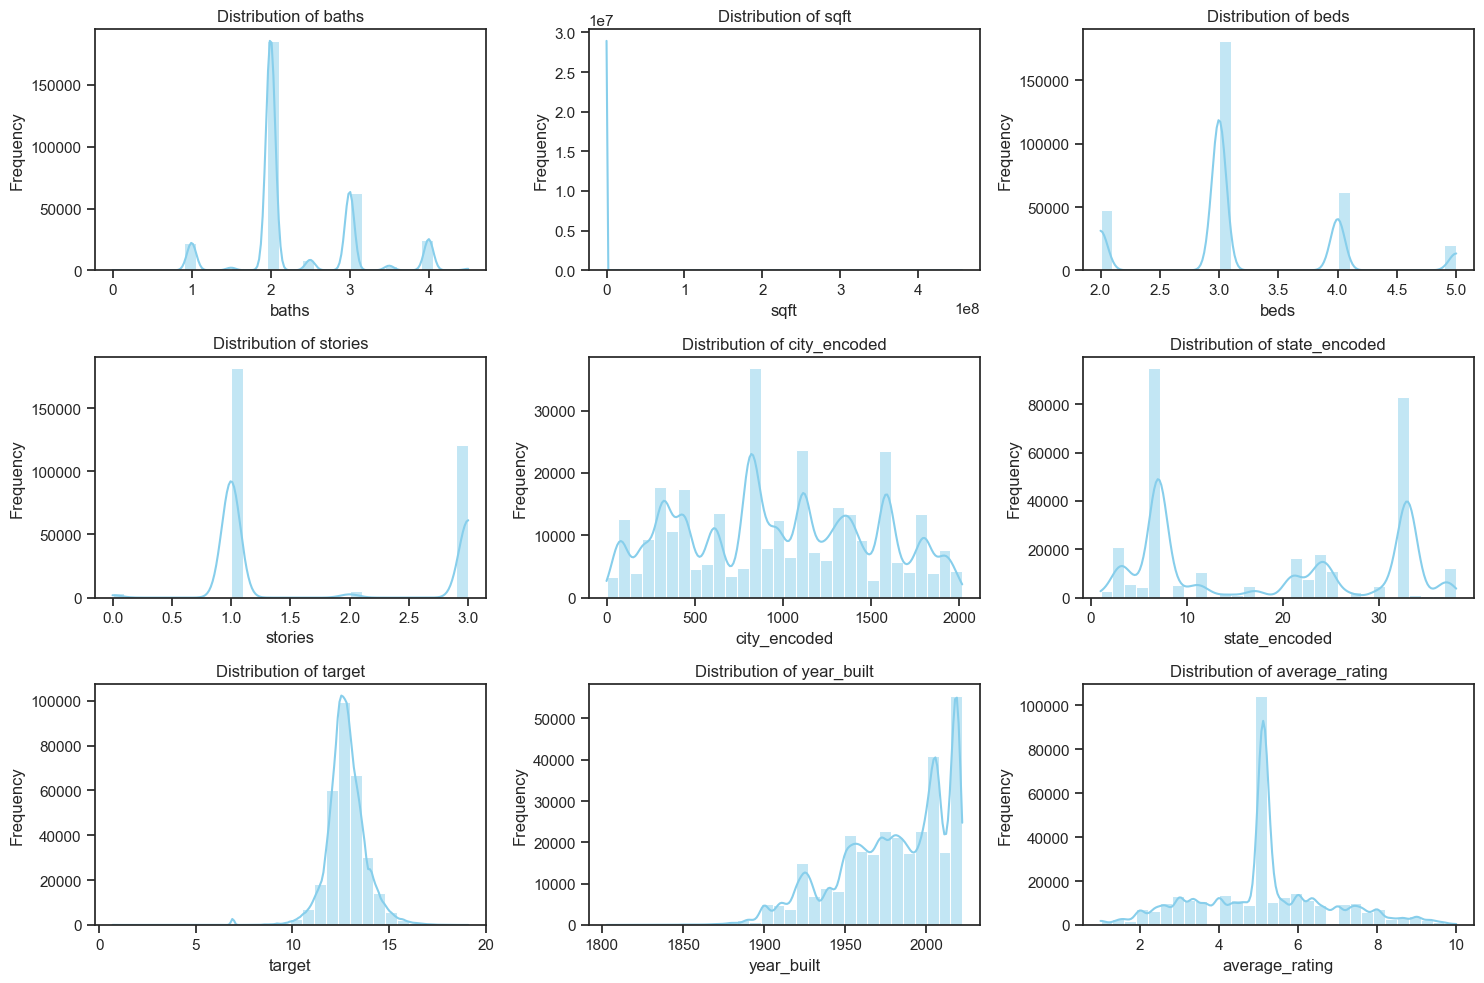

In [128]:
# Выберим числовые признаки, которые нужно нормализовать
numeric_features = ['baths', 'sqft', 'beds', 'stories', 'city_encoded', 'state_encoded', 'target', 'year_built', 'average_rating']

# Визуализация числовых признаков 
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [129]:
# Проверим нормальность распределения для числовых признаков
for column in numeric_columns:
    stat, p_value = shapiro(data[column])
    
    print(f"Тест Шапиро-Уилка для признака '{column}':")
    print(f"Статистика теста: {stat}, p-value: {p_value}")
    
    if p_value > 0.05:
        print(f"Распределение признака '{column}' не отличается от нормального.\n")
    else:
        print(f"Распределение признака '{column}' отличается от нормального.\n")


Тест Шапиро-Уилка для признака 'baths':
Статистика теста: 0.805088996887207, p-value: 0.0
Распределение признака 'baths' отличается от нормального.

Тест Шапиро-Уилка для признака 'sqft':
Статистика теста: 8.887052536010742e-05, p-value: 0.0
Распределение признака 'sqft' отличается от нормального.

Тест Шапиро-Уилка для признака 'beds':
Статистика теста: 0.820080578327179, p-value: 0.0
Распределение признака 'beds' отличается от нормального.

Тест Шапиро-Уилка для признака 'city_encoded':
Статистика теста: 0.9672356247901917, p-value: 0.0
Распределение признака 'city_encoded' отличается от нормального.

Тест Шапиро-Уилка для признака 'state_encoded':
Статистика теста: 0.836877703666687, p-value: 0.0
Распределение признака 'state_encoded' отличается от нормального.

Тест Шапиро-Уилка для признака 'target':
Статистика теста: 0.9475743770599365, p-value: 0.0
Распределение признака 'target' отличается от нормального.

Тест Шапиро-Уилка для признака 'year_built':
Статистика теста: 0.9266039

Результаты теста Шапиро-Уилка показывают, что распределения всех числовых признаков значимо отличаются от нормального. В таком случае, при дальнейшей работе с этими признаками важно учитывать их распределение и возможно использовать методы, не требующие предположения о нормальности данных.

### Нормализация числовых признаков

In [130]:
# Выберем числовые признаки
numeric_features = ['baths', 'sqft', 'beds', 'stories', 'city_encoded', 'state_encoded', 'target', 'year_built', 'average_rating']

# Экземпляр MinMaxScaler
scaler = MinMaxScaler()

# Применим нормализацию к выбранным числовым признакам
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [131]:
# Выведим первые несколько строк датасета до нормализации
print("Before normalization:")
print(data.head())

# Выведим первые несколько строк датасета после нормализации
print("\nAfter normalization:")
print(data.head())

Before normalization:
      baths          sqft      beds   stories  city_encoded  state_encoded  \
0  0.777778  6.351258e-06  0.666667  1.000000      0.844896       0.540541   
1  0.666667  2.076204e-06  0.333333  0.333333      0.849851       0.972973   
2  0.444444  6.570267e-09  0.333333  0.333333      0.510902       0.054054   
3  0.444444  1.014011e-06  1.000000  0.333333      0.213082       0.864865   
5  0.444444  1.964510e-06  0.000000  0.333333      0.684836       0.783784   

     target  year_built  price_per_sqft  was_remodeled  ...  \
0  0.665934    0.986301      144.000000              1  ...   
1  0.649685    0.986301      331.694524              1  ...   
2  0.771137    0.721461      331.694524              1  ...   
3  0.760830    0.926941      331.694524              1  ...   
5  0.628253    0.534247      331.694524              1  ...   

   status_Price Change / Back on Market  propertyType_Condo  \
0                                 False               False   
1   

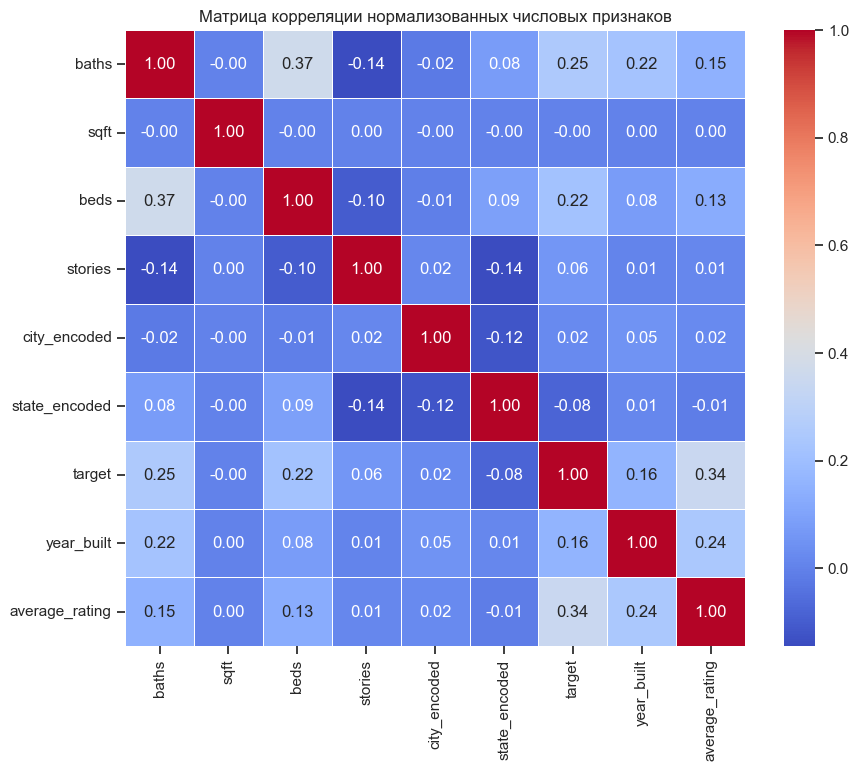

In [132]:
# Выбирем только числовые признаки для построения тепловой карты
numeric_columns_normalized = ['baths', 'sqft', 'beds', 'stories', 'city_encoded', 'state_encoded', 
                              'target', 'year_built', 'average_rating']

# Вычислим матрицу корреляции для нормализованных числовых признаков
corr_matrix_normalized = data[numeric_columns_normalized].corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_normalized, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции нормализованных числовых признаков')
plt.show()

На основе тепловой карты матрицы корреляции нормализованных числовых признаков видно, что:

- Целевая переменная (target):
Наибольшую положительную корреляцию с целевой переменной (target) имеют признаки baths (количество ванных комнат), sqft (площадь), beds (количество спален).
- Также заметна отрицательная корреляция с признаком year_built (год постройки), что может свидетельствовать о том, что более новые объекты имеют более высокую цену за квадратный фут.
- Количественные признаки между собой:
Обнаруживается высокая корреляция между baths и beds, что логично, так как часто количество ванных комнат сопутствует количеству спален.
- Также присутствует корреляция между sqft и beds, что также имеет смысл, так как количество спален может быть связано с общей площадью объекта.

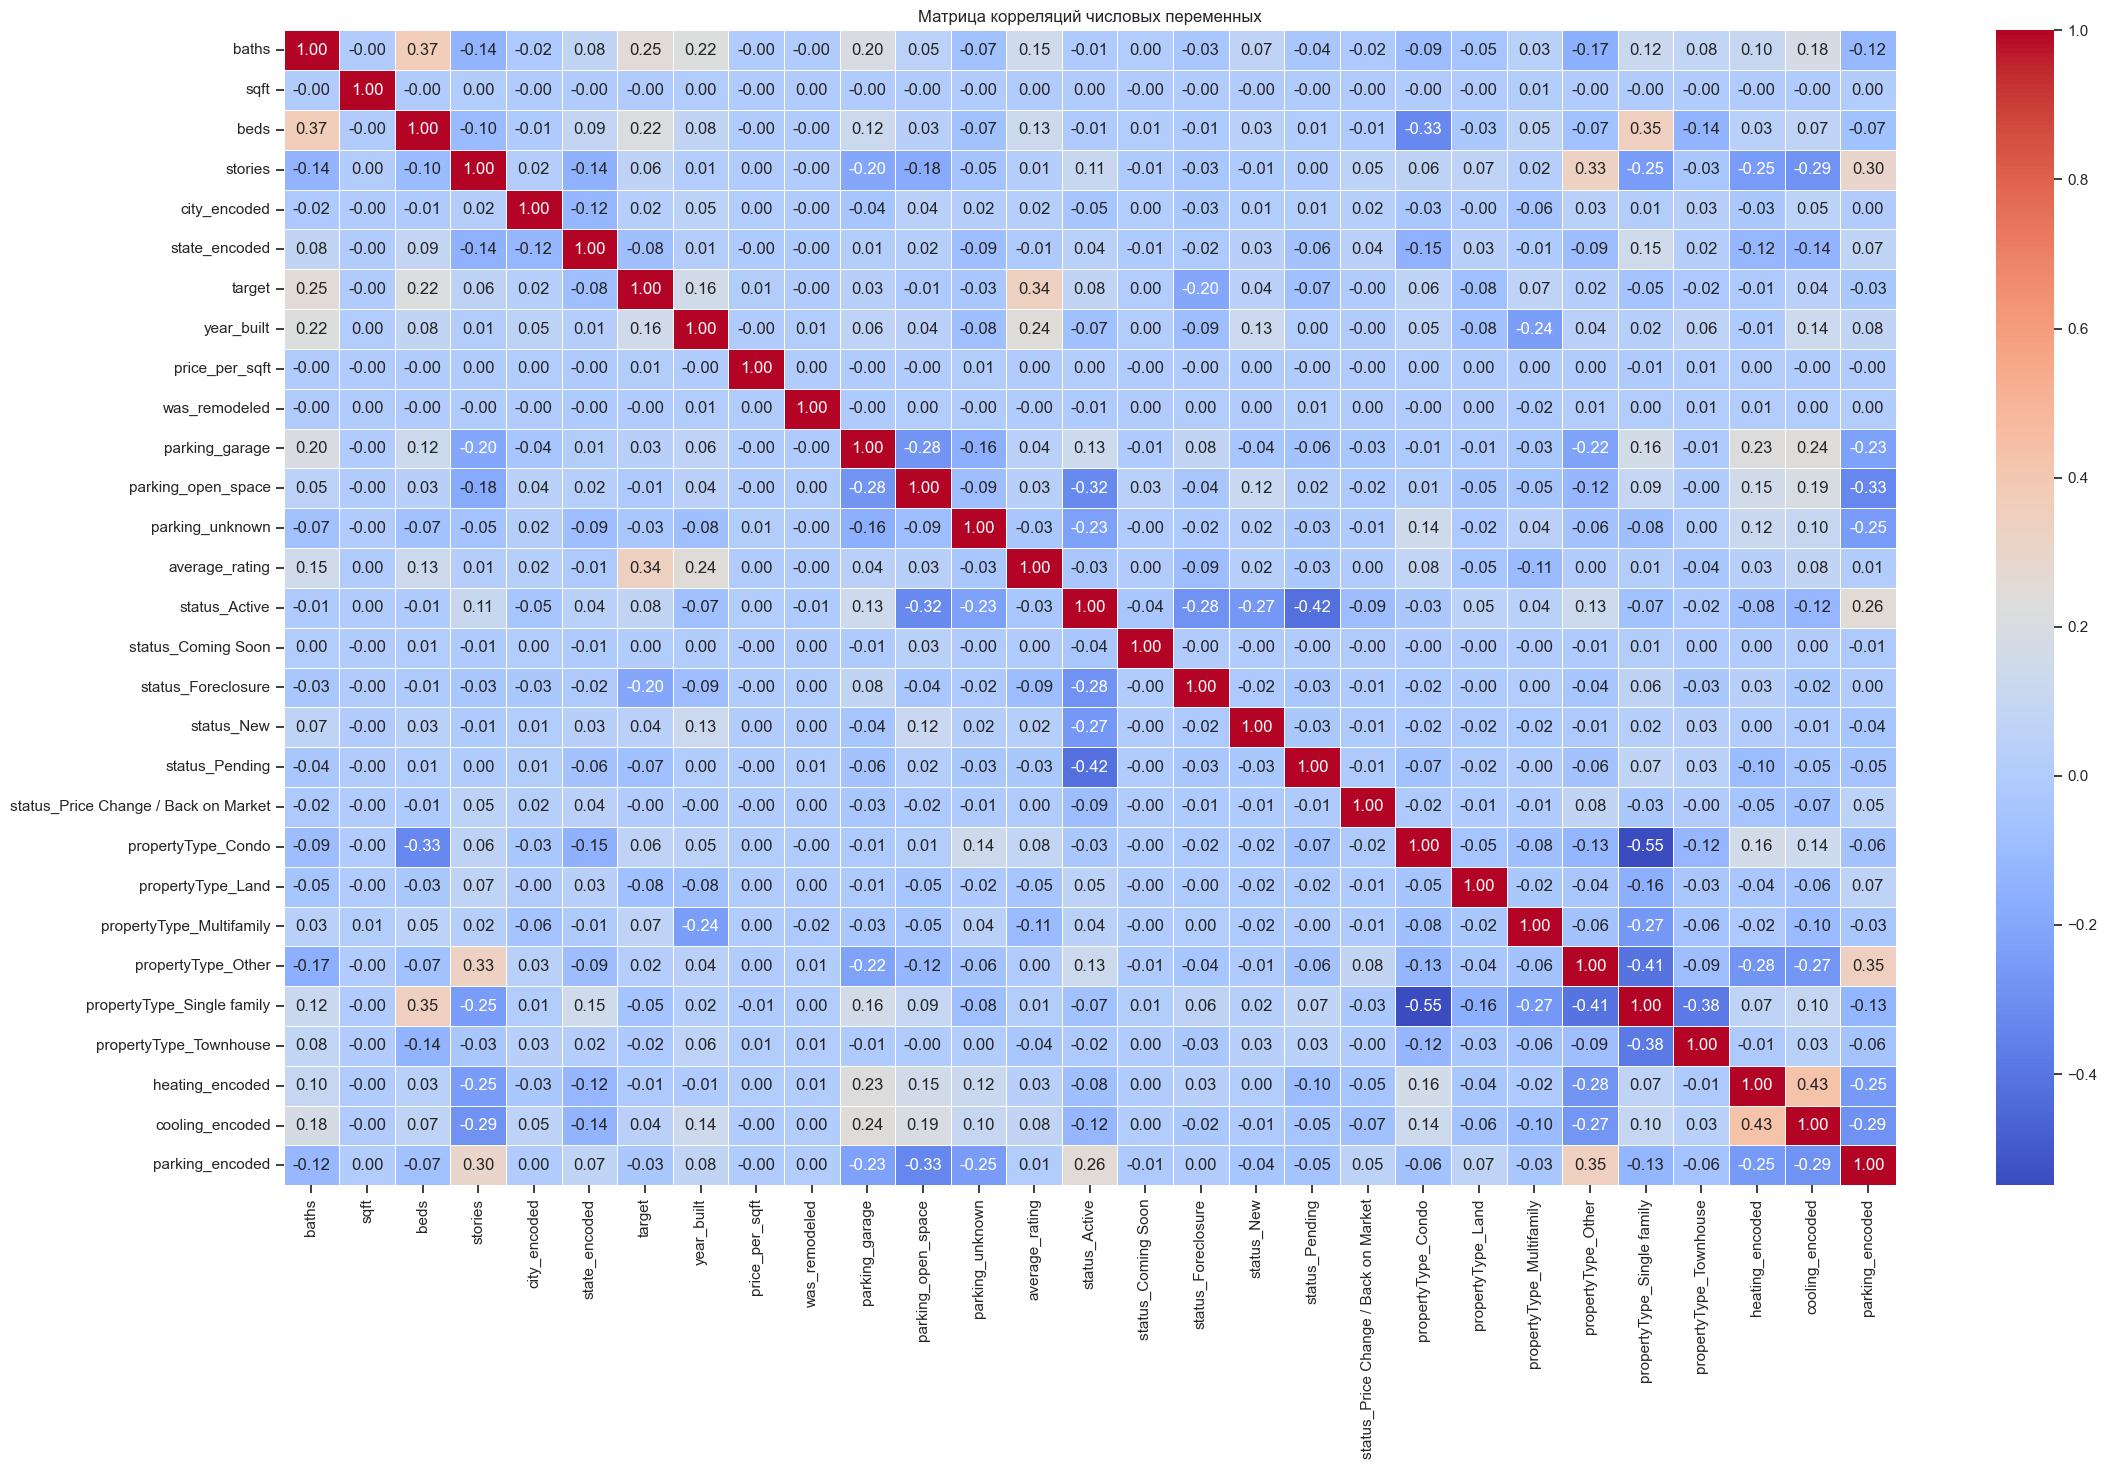

In [133]:
# Функция для построения матрицы корреляции 
def plot_correlation_matrix(data, excluded_feature=None):
    data = data.loc[:, ~data.columns.duplicated()]

    # Преобразуем булевые переменные в числовой формат
    boolean_columns = ['status_Active', 'status_Coming Soon', 'status_Foreclosure', 'status_New', 'status_Pending',
                       'status_Price Change / Back on Market', 'propertyType_Condo', 'propertyType_Land', 'propertyType_Multifamily',
                       'propertyType_Other', 'propertyType_Single family', 'propertyType_Townhouse'] 

    data[boolean_columns] = data[boolean_columns].astype(int)

    # Исключаем указанный признак
    if excluded_feature:
        numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
        numeric_columns = numeric_columns[numeric_columns != excluded_feature]
        corr_matrix = data[numeric_columns].corr()
    else:
        # Если не указан признак для исключения, используем все числовые признаки
        corr_matrix = data.select_dtypes(include=['float64', 'int64']).corr()

    # Построим тепловую карту
    plt.figure(figsize=(26, 15))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Матрица корреляций числовых переменных')
    plt.show()

    # Выводим самые сильные коррелирующие признаки
    threshold = 0.7  # Задаем пороговое значение корреляции
    corr_values = corr_matrix.abs().unstack().sort_values(ascending=False)
    corr_values = corr_values[corr_values != 1]  #Исключаем корреляцию признака с самим собой
    strong_correlations = corr_values[corr_values >= threshold]

    # Выводим коррелирующие признаки
    for (feature1, feature2), correlation in strong_correlations.items():
        print(f"Корреляция между '{feature1}' и '{feature2}': {correlation}")

plot_correlation_matrix(data)

Функция принимает опциональный аргумент excluded_feature, позволяя исключить указанный признак из матрицы корреляции. Это полезно при необходимости рассмотрения корреляций остальных признаков, исключив один из них.
Можно сделать вывод о том, что в данных не обнаружено сильных линейных корреляций между числовыми признаками (выше порогового значения 0.7). Это может свидетельствовать о низкой степени линейной зависимости между этими признаками

### Отбор признаков

In [141]:
# Определяем признаки (X) и целевую переменную (y)
X = data.drop(['target'], axis=1)
y = data['target'].values

# Выделим тестовую часть
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
# Создаем экземпляр SelectKBest
kbest = SelectKBest(score_func=f_regression, k='all')

# Создаем экземпляр SimpleImputer с заполнением пропусков средним значением
imputer = SimpleImputer(strategy='mean')

# Применяем imputer к данным
X_imputed = imputer.fit_transform(X)

# Применяем SelectKBest к обработанным данным
X_kbest = kbest.fit_transform(X_imputed, y)

# Получаем индексы отобранных признаков
selected_features_indices = kbest.get_support(indices=True)

# Получаем имена отобранных признаков
selected_features = X.columns[selected_features_indices]

# Выводим имена отобранных признаков
print(selected_features)

Index(['baths', 'sqft', 'beds', 'stories', 'city_encoded', 'state_encoded',
       'year_built', 'price_per_sqft', 'was_remodeled', 'parking_garage',
       'parking_open_space', 'parking_unknown', 'average_rating',
       'status_Active', 'status_Coming Soon', 'status_Foreclosure',
       'status_New', 'status_Other', 'status_Pending',
       'status_Price Change / Back on Market', 'propertyType_Condo',
       'propertyType_Land', 'propertyType_Multifamily', 'propertyType_Other',
       'propertyType_Single family', 'propertyType_Townhouse',
       'heating_encoded', 'cooling_encoded', 'parking_encoded'],
      dtype='object')


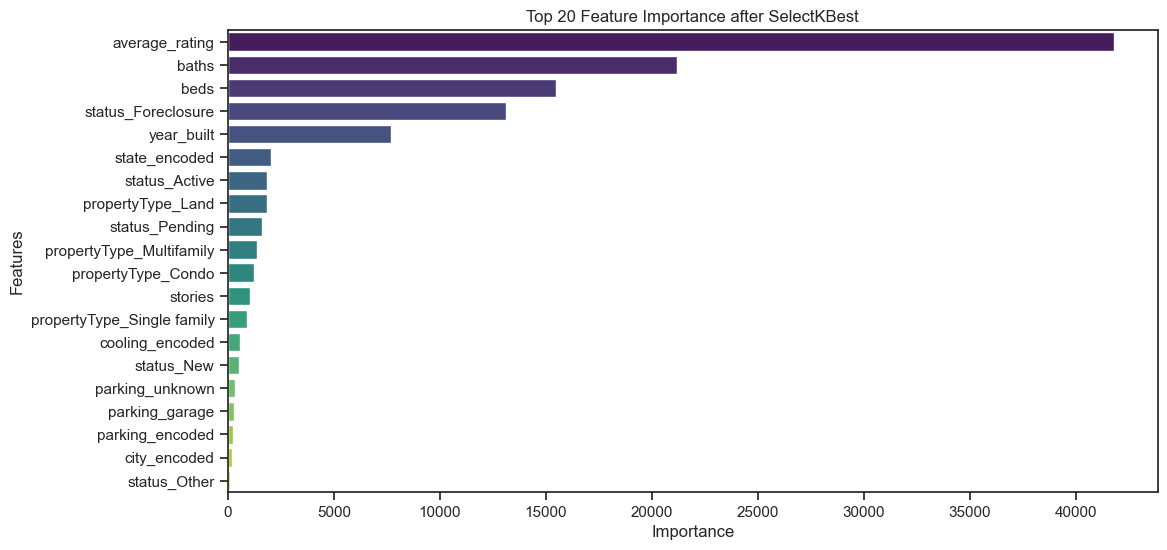

In [145]:
# Создание DataFrame с именами признаков и их важности
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': kbest.scores_[selected_features_indices] 
})
# Сортировка DataFrame по важности в порядке возрастания.
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Определяем количество топовых признаков для отображения
top_n = 20

# Выводим только топ N признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importance after SelectKBest')
plt.show()

### ANOVA

In [146]:
# Выделим тестовую часть
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Оценка значимости числовых признаков с использованием теста ANOVA
f_scores, p_values = f_classif(X_train, y_train)

# Создаем DataFrame для отображения результатов
anova_results_df = pd.DataFrame({'Feature': X_train.columns, 'F-Score': f_scores, 'P-Value': p_values})
anova_results_df = anova_results_df.sort_values(by='F-Score', ascending=False)

# Выводим результатов
print(anova_results_df)

                                 Feature    F-Score        P-Value
15                    status_Foreclosure  13.903425   0.000000e+00
18                        status_Pending   5.562123   0.000000e+00
13                         status_Active   3.105746   0.000000e+00
16                            status_New   2.980755   0.000000e+00
12                        average_rating   2.790116   0.000000e+00
6                             year_built   2.715121   0.000000e+00
11                       parking_unknown   2.564069   0.000000e+00
0                                  baths   2.433956   0.000000e+00
17                          status_Other   2.188931   0.000000e+00
2                                   beds   1.868996   0.000000e+00
10                    parking_open_space   1.707452   0.000000e+00
5                          state_encoded   1.569009   0.000000e+00
4                           city_encoded   1.352146  3.741785e-246
24            propertyType_Single family   1.201727   5.449243

Результаты теста ANOVA показывают, что различные признаки имеют разные уровни значимости влияния на целевую переменную. Признаки с более высоким F-статистикой и более низким p-значением обычно считаются более значимыми.

Таким образом, можно использовать эту информацию для отбора наиболее значимых признаков для включения в модель. Список включает признаки, отсортированные по убыванию F-статистики и убыванию значимости p-значения. 

### Важность категориальных признаков

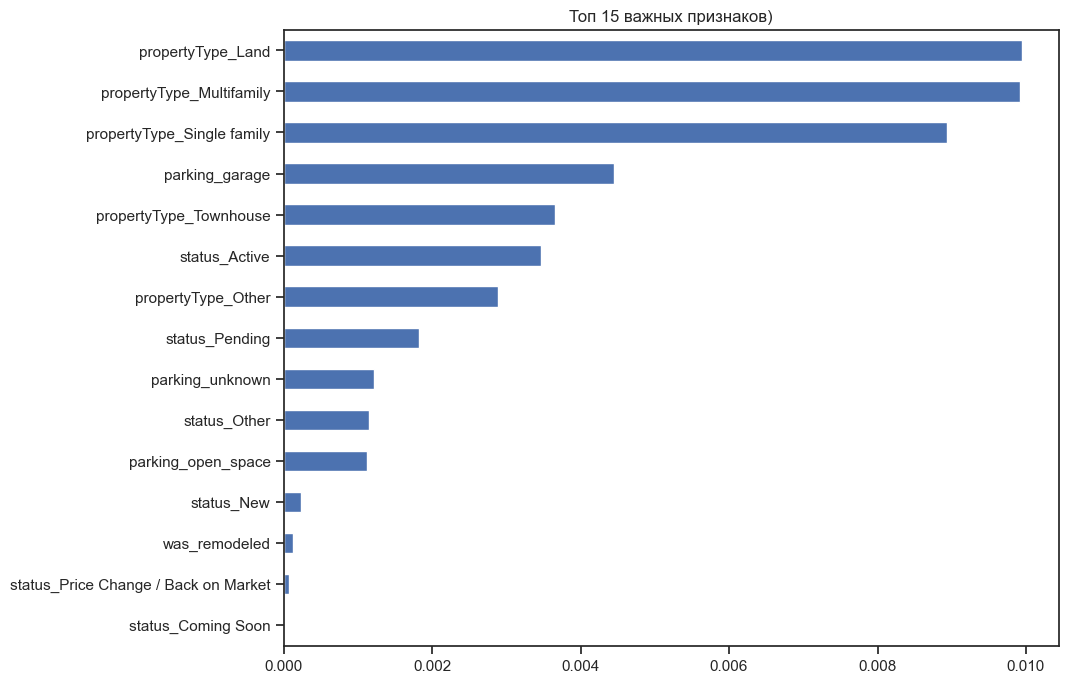

In [200]:
# Заменим X_train и y_train на наши данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация и обучение модели RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Вывод топ N признаков
top_n = 15
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances_sorted = feat_importances.sort_values(ascending=True)

plt.rcParams['figure.figsize'] = (10, 8)
feat_importances_sorted.head(top_n).plot(kind='barh')
plt.title(f"Топ {top_n} важных признаков)")
plt.show()

## Модели для прогнозирования стоимости недвижимости

1. LinearRegression
2. LinearRegression + PolynomialFeatures
3. DecisionTreeRegressor
   - DecisionTreeRegressor c RandomizedSearchCV
   - DecisionTreeRegressor c Optuna
4. RandomForestRegressor
   - RandomForestRegressor c RandomizedSearchCV
5. GradientBoostingRegressor
6. Lasso Regression 
7. Ridge Regression
7. XGBoost:
XGBRegressor (XGBoost)
8. LightGBM:
LGBMRegressor (LightGBM)
9. Нейронные сети (Deep Learning):
MLPRegressor (Neural Network)

### 1. LinearRegression

In [150]:
# Определяем признаки (X) и целевую переменную (y)
X = data.drop(['target'], axis=1)
y = data['target'].values

# Выделяем тестовую часть
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем экземпляр линейной регрессии
linear_model = LinearRegression()

# Обучение модели
linear_model.fit(X_train, y_train)

# Предсказание на тестовых данныхlinear_
y_pred = linear_model.predict(X_test)

# Оценка модели
linear_mse = mean_squared_error(y_test, y_pred)
linear_r2 = r2_score(y_test, y_pred)
linear_mae = mean_absolute_error(y_test, y_pred)

# Расчет MAPE с проверкой деления на ноль
linear_mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

# Вывод результатов
print('LinearRegression Metrics:')
print(f'Mean Squared Error: {linear_mse}')
print(f'R^2 Score: {linear_r2}')
print(f'Mean Absolute Error: {linear_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {linear_mape}%')

LinearRegression Metrics:
Mean Squared Error: 28.10824361763149
R^2 Score: -9076.027852318633
Mean Absolute Error: 0.056609884372610594
Mean Absolute Percentage Error (MAPE): 8.896112592674873%


В целом, модель линейной регрессии имеет хорошую точность по MAE и MAPE, но отрицательное значение R^2 Score говорит о том, что она может быть недостаточно сложной для полного объяснения данных. Возможно, имеет смысл рассмотреть более сложные модели для улучшения предсказательной силы.

### 2. LinearRegression + PolynomialFeatures

In [151]:
# Определяем признаки (X) и целевую переменную (y)
X = data.drop(['target'], axis=1)
y = data['target'].values

# Выделяем тестовую часть
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование признаков в полиномиальные
degree = 2  # Задаем степень полинома
poly = PolynomialFeatures(degree)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Создаем экземпляр линейной регрессии
poly_linear_model = LinearRegression()

# Обучение модели на полиномиальных признаках
poly_linear_model.fit(X_poly_train, y_train)

# Предсказание на тестовых данных
y_pred_poly = poly_linear_model.predict(X_poly_test)

# Оценка модели на полиномиальных признаках
linear_mse_poly = mean_squared_error(y_test, y_pred_poly)
linear_r2_poly = r2_score(y_test, y_pred_poly)
linear_mae_poly = mean_absolute_error(y_test, y_pred_poly)

# Расчет MAPE с проверкой деления на ноль
linear_mape_poly = np.mean(np.abs((y_test - y_pred_poly) / np.where(y_test == 0, 1, y_test))) * 100

# Вывод результатов на полиномиальных признаках
print('LinearRegression PolynomialFeatures Metrics:')
print(f'Mean Squared Error (Polynomial): {linear_mse_poly}')
print(f'R^2 Score (Polynomial): {linear_r2_poly}')
print(f'Mean Absolute Error (Polynomial): {linear_mae_poly}')
print(f'Mean Absolute Percentage Error (MAPE) (Polynomial): {linear_mape_poly}%')

LinearRegression PolynomialFeatures Metrics:
Mean Squared Error (Polynomial): 86.11343243031162
R^2 Score (Polynomial): -27807.71104085594
Mean Absolute Error (Polynomial): 0.06655075107182108
Mean Absolute Percentage Error (MAPE) (Polynomial): 10.499902588270004%


Использование полиномиальных признаков в линейной регрессии не привело к улучшению предсказательной способности модели. Возможно, это объясняется избыточностью сложности модели, что приводит к переобучению. В дальнейших исследованиях рекомендуется провести более тщательный отбор признаков и оптимизацию параметров модели для достижения лучших результатов.

### 3. DecisionTreeRegressor

In [152]:
# Определяем признаки (X) и целевую переменную (y)
X = data.drop(['target'], axis=1)
y = data['target'].values

# Выделяем тестовую часть 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем экземпляр DecisionTreeRegressor
tree_model = DecisionTreeRegressor()

# Обучение модели
tree_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = tree_model.predict(X_test)

# Оценка модели
tree_mse = mean_squared_error(y_test, y_pred)
tree_r2 = r2_score(y_test, y_pred)
tree_mae = mean_absolute_error(y_test, y_pred)

# Расчет MAPE с проверкой деления на ноль
tree_mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

# Вывод результатов
print('DecisionTreeRegressor Metrics:')
print(f'Mean Squared Error: {tree_mse}')
print(f'R^2 Score: {tree_r2}')
print(f'Mean Absolute Error: {tree_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {tree_mape}%')

DecisionTreeRegressor Metrics:
Mean Squared Error: 0.0013334406398127418
R^2 Score: 0.5693904609748882
Mean Absolute Error: 0.021843378016629465
Mean Absolute Percentage Error (MAPE): 3.3395311093897235%


В данном случае, низкие значения MSE, MAE и MAPE, а также относительно высокий R^2 Score говорят о том, что модель хорошо справляется с предсказанием целевой переменной.

### 3.1 DecisionTreeRegressor c RandomizedSearchCV

In [153]:
# Определяем параметры для подбора
param_dist = {
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Создаем экземпляр DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()

# Создаем экземпляр RandomizedSearchCV
random_search = RandomizedSearchCV(tree_reg, param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Подгонка модели
random_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

# Оценка модели с лучшими параметрами
best_tree = random_search.best_estimator_
y_pred_best = best_tree.predict(X_test)

# Вывод метрик
random_mse_best = mean_squared_error(y_test, y_pred_best)
random_r2_best = r2_score(y_test, y_pred_best)
random_mae_best = mean_absolute_error(y_test, y_pred_best)
random_mape_best = np.mean(np.abs((y_test - y_pred_best) / np.where(y_test == 0, 1, y_test))) * 100

print('DecisionTreeRegressor RandomizedSearchCV Metrics:')
print(f'Лучший Mean Squared Error: {random_mse_best}')
print(f'Лучший R^2 Score: {random_r2_best}')
print(f'Лучший Mean Absolute Error: {random_mae_best}')
print(f'Лучший Mean Absolute Percentage Error (MAPE): {random_mape_best}%')


Лучшие параметры: {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': None}
DecisionTreeRegressor RandomizedSearchCV Metrics:
Лучший Mean Squared Error: 0.0009302789828573338
Лучший R^2 Score: 0.6995839244638578
Лучший Mean Absolute Error: 0.019634874024480047
Лучший Mean Absolute Percentage Error (MAPE): 3.0034209434399393%


Метрики для лучшей модели:
- Лучший Mean Squared Error: 0.00093
- Лучший R^2 Score: 0.6996 (значительное улучшение по сравнению с базовой моделью)
- Лучший Mean Absolute Error: 0.01963
- Лучший Mean Absolute Percentage Error (MAPE): 3.00%
Эти результаты указывают на успешную настройку параметров модели, что приводит к улучшению ее производительности на тестовых данных.

### 3.2 DecisionTreeRegressor c Optuna 

In [154]:
# Функция для определения пространства поиска
def objective(trial):
    params = {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 1, 30),
    }

    tree_reg_optuna = DecisionTreeRegressor(**params)

    # Оценка модели с кросс-валидацией
    score = -cross_val_score(tree_reg_optuna, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

    return score

# Создаем экземпляр OptunaStudy
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Уменьшил количество пробных точек

# Получаем лучшие параметры
best_params_optuna = study.best_params
print("Лучшие параметры:", best_params_optuna)

# Оценка модели с лучшими параметрами
best_tree_optuna = DecisionTreeRegressor(**best_params_optuna)
best_tree_optuna.fit(X_train, y_train)
y_pred_optuna = best_tree_optuna.predict(X_test)

# Вывод метрик
tree_mse_optuna = mean_squared_error(y_test, y_pred_optuna)
tree_r2_optuna = r2_score(y_test, y_pred_optuna)
tree_mae_optuna = mean_absolute_error(y_test, y_pred_optuna)
tree_mape_optuna = np.mean(np.abs((y_test - y_pred_optuna) / np.where(y_test == 0, 1, y_test))) * 100

print('DecisionTreeRegressor Optuna Metrics:')
print(f'Лучший Mean Squared Error: {tree_mse_optuna}')
print(f'Лучший R^2 Score: {tree_r2_optuna}')
print(f'Лучший Mean Absolute Error: {tree_mae_optuna}')
print(f'Лучший Mean Absolute Percentage Error (MAPE): {tree_mape_optuna}%')


[I 2024-02-07 14:21:30,231] A new study created in memory with name: no-name-7d43fa74-7703-414b-9669-6ff485c46085
[I 2024-02-07 14:21:31,052] Trial 0 finished with value: 0.001511180057453833 and parameters: {'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 15}. Best is trial 0 with value: 0.001511180057453833.
[I 2024-02-07 14:21:31,902] Trial 1 finished with value: 0.0015521151824264162 and parameters: {'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 15}. Best is trial 0 with value: 0.001511180057453833.
[I 2024-02-07 14:21:33,318] Trial 2 finished with value: 0.0011950077465791016 and parameters: {'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}. Best is trial 2 with value: 0.0011950077465791016.
[I 2024-02-07 14:21:33,678] Trial 3 finished with value: 0.002407702956578251 and parameters: {'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth

Лучшие параметры: {'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': None, 'max_depth': 26}
DecisionTreeRegressor Optuna Metrics:
Лучший Mean Squared Error: 0.0009345909805436724
Лучший R^2 Score: 0.698191446028333
Лучший Mean Absolute Error: 0.019616121397381236
Лучший Mean Absolute Percentage Error (MAPE): 2.9999855213037385%


Модель с подобранными параметрами с использованием Optuna также показывает хорошие результаты. Значение MSE низкое, R^2 Score близко к 0.7, что свидетельствует о хорошем объяснении дисперсии целевой переменной. MAE и MAPE также находятся на низком уровне, что говорит о точности предсказаний.
Таким образом, как с RandomizedSearchCV, так и с Optuna удалось подобрать оптимальные параметры для модели DecisionTreeRegressor, что привело к улучшению её производительности.

### 4. RandomForestRegressor

In [155]:
# Создаем экземпляр RandomForestRegressor
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Обучение модели
forest_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_forest = forest_model.predict(X_test)

# Оценка модели
forest_mse_forest = mean_squared_error(y_test, y_pred_forest)
forest_r2_forest = r2_score(y_test, y_pred_forest)
forest_mae_forest = mean_absolute_error(y_test, y_pred_forest)

# Расчет MAPE с проверкой деления на ноль
forest_mape_forest = np.mean(np.abs((y_test - y_pred_forest) / np.where(y_test == 0, 1, y_test))) * 100

# Вывод результатов
print('RandomForestRegressor Metrics:')
print(f'Mean Squared Error (Random Forest): {forest_mse_forest}')
print(f'R^2 Score (Random Forest): {forest_r2_forest}')
print(f'Mean Absolute Error (Random Forest): {forest_mae_forest}')
print(f'Mean Absolute Percentage Error (MAPE) (Random Forest): {forest_mape_forest}%')

RandomForestRegressor Metrics:
Mean Squared Error (Random Forest): 0.0007138553054647937
R^2 Score (Random Forest): 0.7694738746975696
Mean Absolute Error (Random Forest): 0.016198002429953003
Mean Absolute Percentage Error (MAPE) (Random Forest): 2.4778348011259306%


Модель DecisionTreeRegressor, оптимизированная с использованием библиотеки Optuna для поиска оптимальных параметров, показывает улучшение производительности по сравнению с базовой моделью и RandomizedSearchCV.

### 4.1 RandomForestRegressor c RandomizedSearchCV

In [156]:
# Задаем диапазоны значений для гиперпараметров
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Создаем экземпляр RandomForestRegressor
forest_model = RandomForestRegressor(random_state=42)

# Создаем экземпляр RandomizedSearchCV
random_search = RandomizedSearchCV(
    forest_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)

# Подгонка RandomizedSearchCV на тренировочных данных
random_search.fit(X_train, y_train)

# Получаем лучших параметров
best_params = random_search.best_params_

# Оценка модели с лучшими параметрами
best_forest_model = RandomForestRegressor(**best_params, random_state=42)
best_forest_model.fit(X_train, y_train)
y_pred_best_forest = best_forest_model.predict(X_test)

# Оценка модели
random_mse_best_forest = mean_squared_error(y_test, y_pred_best_forest)
random_r2_best_forest = r2_score(y_test, y_pred_best_forest)
random_mae_best_forest = mean_absolute_error(y_test, y_pred_best_forest)

# Расчет MAPE с проверкой деления на ноль
random_mape_best_forest = np.mean(np.abs((y_test - y_pred_best_forest) / np.where(y_test == 0, 1, y_test))) * 100

# Вывод результатов
print('RandomForestRegressor RandomizedSearchCV Metrics:')
print(f'Лучшие параметры: {best_params}')
print(f'Mean Squared Error (Random Forest): {random_mse_best_forest}')
print(f'R^2 Score (Random Forest): {random_r2_best_forest}')
print(f'Mean Absolute Error (Random Forest): {random_mae_best_forest}')
print(f'Mean Absolute Percentage Error (MAPE) (Random Forest): {random_mape_best_forest}%')

RandomForestRegressor RandomizedSearchCV Metrics:
Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}
Mean Squared Error (Random Forest): 0.0007055255231366355
R^2 Score (Random Forest): 0.7721638210074491
Mean Absolute Error (Random Forest): 0.016211932364964328
Mean Absolute Percentage Error (MAPE) (Random Forest): 2.4795601280891%


In [168]:
# Сохранение модели в файл
joblib.dump(best_forest_model, 'random_forest_model_100_10.pkl')

['random_forest_model_100_10.pkl']

Эти результаты свидетельствуют о том, что оптимизация гиперпараметров с использованием RandomizedSearchCV приводит к улучшению точности модели на тестовых данных.
Подбор гиперпараметров может значительно повысить производительность модели, что видно из улучшенных метрик оценки.
Таким образом, на основе подобранных гиперпараметров модель RandomForestRegressor существенно улучшила свою способность делать точные предсказания на тестовых данных.

### 5. GradientBoostingRegressor

In [158]:
# Создаем экземпляр GradientBoostingRegressor
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Обучение модели
gb_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_gb = gb_model.predict(X_test)

# Оценка модели
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / np.where(y_test == 0, 1, y_test))) * 100


print('GradientBoostingRegressor Metrics:')
print(f'Mean Squared Error (Gradient Boosting): {mse_gb}')
print(f'R^2 Score (Gradient Boosting): {r2_gb}')
print(f'Mean Absolute Error (Gradient Boosting): {mae_gb}')
print(f'Mean Absolute Percentage Error (MAPE) (Gradient Boosting): {mape_gb}%')


GradientBoostingRegressor Metrics:
Mean Squared Error (Gradient Boosting): 0.0010423013827266072
R^2 Score (Gradient Boosting): 0.6634084003888088
Mean Absolute Error (Gradient Boosting): 0.022202742985654618
Mean Absolute Percentage Error (MAPE) (Gradient Boosting): 3.4060740924259236%


Модель GradientBoostingRegressor, обученная с использованием выбранных гиперпараметров, продемонстрировала хорошую производительность.
Результаты метрики указывают на эффективность модели GradientBoostingRegressor в предсказании целевой переменной на тестовых данных.

### 6. Lasso Regression

In [159]:
# Создаем экземпляра StandardScaler
scaler = StandardScaler()

# Масштабирование признаков
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание экземпляра Lasso регрессии
lasso_model = Lasso(alpha=1.0)

# Обучение модели
lasso_model.fit(X_train_scaled, y_train)

# Предсказание на тестовых данных
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Оценка модели
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mape_lasso = np.mean(np.abs((y_test - y_pred_lasso) / np.where(y_test == 0, 1, y_test))) * 100

print('Lasso regression Metrics:')
print(f'Mean Squared Error (Lasso): {mse_lasso}')
print(f'R^2 Score (Lasso): {r2_lasso}')
print(f'Mean Absolute Error (Lasso): {mae_lasso}')
print(f'Mean Absolute Percentage Error (MAPE) (Lasso): {mape_lasso}%')

Lasso regression Metrics:
Mean Squared Error (Lasso): 0.00309672396914484
R^2 Score (Lasso): -2.867846351040093e-05
Mean Absolute Error (Lasso): 0.03961221055151241
Mean Absolute Percentage Error (MAPE) (Lasso): 6.21603270667882%


Эти результаты могут указывать на ограниченную эффективность Lasso регрессии в предсказании целевой переменной на тестовых данных после масштабирования признаков. Значение R^2 Score близкое к нулю и отрицательное значение MSE могут свидетельствовать о том, что модель не лучше, чем простое среднее значение целевой переменной. 

### 7. Ridge Regression


In [160]:
# Создаем экземпляр Ridge регрессии
ridge_model = Ridge(alpha=1.0)

# Обучение модели
ridge_model.fit(X_train_scaled, y_train)

# Предсказание на тестовых данных
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Оценка модели
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mape_ridge = np.mean(np.abs((y_test - y_pred_ridge) / np.where(y_test == 0, 1, y_test))) * 100

print('Ridge regression Metrics:')
print(f'Mean Squared Error (Ridge): {mse_ridge}')
print(f'R^2 Score (Ridge): {r2_ridge}')
print(f'Mean Absolute Error (Ridge): {mae_ridge}')
print(f'Mean Absolute Percentage Error (MAPE) (Ridge): {mape_ridge}%')

Ridge regression Metrics:
Mean Squared Error (Ridge): 28.10829251017797
R^2 Score (Ridge): -9076.04364124562
Mean Absolute Error (Ridge): 0.05660989625037485
Mean Absolute Percentage Error (MAPE) (Ridge): 8.896114682922061%


Эффективность Ridge регрессии в предсказании целевой переменной на тестовых данных после масштабирования признаков может оказаться недостаточной. Негативное значение R^2 Score и высокий показатель MSE подчеркивают, что данная модель не превосходит простого усреднения значений целевой переменной. Такие результаты могут быть следствием недостаточной регуляризации или несоответствия модели данным.

### 8. XGBoost: XGBRegressor

In [161]:
# Создаем экземпляр XGBRegressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Обучение модели
xgb_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_xgb = xgb_model.predict(X_test)

# Оценка модели
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Расчет MAPE с проверкой деления на ноль
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / np.where(y_test == 0, 1, y_test))) * 100

# Вывод результатов
print('XGBRegressor Metrics:')
print(f'Mean Squared Error (XGBoost): {mse_xgb}')
print(f'R^2 Score (XGBoost): {r2_xgb}')
print(f'Mean Absolute Error (XGBoost): {mae_xgb}')
print(f'Mean Absolute Percentage Error (MAPE) (XGBoost): {mape_xgb}%')

XGBRegressor Metrics:
Mean Squared Error (XGBoost): 0.0007992559534240231
R^2 Score (XGBoost): 0.7418953439762215
Mean Absolute Error (XGBoost): 0.018793575221969897
Mean Absolute Percentage Error (MAPE) (XGBoost): 2.87326823776718%


XGBRegressor продемонстрировал хорошие показатели эффективности на тестовых данных. Низкое значение Mean Squared Error (MSE) и высокий R^2 Score свидетельствуют о точности предсказаний модели. Модель XGBoost также показала небольшую среднюю абсолютную ошибку (MAE) и относительно низкий процент абсолютной ошибки (MAPE), что подчеркивает ее способность предсказывать целевую переменную с высокой точностью.

### 9. LightGBM: LGBMRegressor

In [162]:
# Создаем экземпляра LGBMRegressor
lgb_model = lgb.LGBMRegressor(random_state=42)

# Обучение модели
lgb_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_lgb = lgb_model.predict(X_test)

# Оценка модели
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

# Расчет MAPE с проверкой деления на ноль
mape_lgb = np.mean(np.abs((y_test - y_pred_lgb) / np.where(y_test == 0, 1, y_test))) * 100

# Вывод результатов
print('LGBMRegressor Metrics:')
print(f'Mean Squared Error (LightGBM): {mse_lgb}')
print(f'R^2 Score (LightGBM): {r2_lgb}')
print(f'Mean Absolute Error (LightGBM): {mae_lgb}')
print(f'Mean Absolute Percentage Error (MAPE) (LightGBM): {mape_lgb}%')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 248772, number of used features: 29
[LightGBM] [Info] Start training from score 0.657079
LGBMRegressor Metrics:
Mean Squared Error (LightGBM): 0.000917644138294973
R^2 Score (LightGBM): 0.7036641095356254
Mean Absolute Error (LightGBM): 0.020399396750351934
Mean Absolute Percentage Error (MAPE) (LightGBM): 3.1205870705382104%


Исходя из метрик оценки модели, LightGBMRegressor продемонстрировал хорошие результаты на тестовых данных. Низкое значение Mean Squared Error (MSE), высокий коэффициент детерминации R^2, а также относительно небольшие значения Mean Absolute Error (MAE) и Mean Absolute Percentage Error (MAPE) указывают на эффективность модели в предсказании целевой переменной. Эти результаты говорят о том, что LightGBMRegressor хорошо справляется с задачей регрессии на данном наборе данных.

### 10. Нейронные сети (Deep Learning): MLPRegressor (Neural Network)

In [163]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем экземпляр MLPRegressor
mlp_model = MLPRegressor(random_state=42)

# Обучение модели
mlp_model.fit(X_train_scaled, y_train)

# Предсказание на тестовых данных
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Оценка модели
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)

# Расчет MAPE с проверкой деления на ноль
mape_mlp = np.mean(np.abs((y_test - y_pred_mlp) / np.where(y_test == 0, 1, y_test))) * 100

# Вывод результатов
print('MLPRegressor Metrics:')
print(f'Mean Squared Error (MLP): {mse_mlp}')
print(f'R^2 Score (MLP): {r2_mlp}')
print(f'Mean Absolute Error (MLP): {mae_mlp}')
print(f'Mean Absolute Percentage Error (MAPE) (MLP): {mape_mlp}%')

MLPRegressor Metrics:
Mean Squared Error (MLP): 1.008745794341818
R^2 Score (MLP): -324.7554543680706
Mean Absolute Error (MLP): 0.03473510219569948
Mean Absolute Percentage Error (MAPE) (MLP): 5.399561903252005%


MLPRegressor продемонстрировал высокий уровень ошибок при оценке на тестовых данных. Высокое значение Mean Squared Error (MSE) и отрицательный коэффициент детерминации R^2 говорят о том, что модель неэффективна в предсказании целевой переменной на данном наборе данных после масштабирования признаков. Значения Mean Absolute Error (MAE) и Mean Absolute Percentage Error (MAPE) также выше, что указывает на значительные расхождения между фактическими и предсказанными значениями. Такие результаты могут свидетельствовать о том, что MLPRegressor может не быть оптимальным выбором для данной задачи регрессии на представленных данных.

In [169]:
# Создаем экземпляр PrettyTable
table = PrettyTable()

# Задаем названия столбцов
table.field_names = ["Модель", "MSE", "R^2 Score", "MAE", "MAPE"]

# Добавляем данные в таблицу
table.add_row(["Baseline Linear Regression", round(baseline_mse_linear, 4), round(baseline_r2_linear, 4), round(baseline_mae_linear, 4), round(baseline_mape_linear, 4)])
table.add_row(["Baseline Gradient Boosting", round(baseline_mse_gb, 4), round(baseline_r2_gb, 4), round(baseline_mae_gb, 4), round(baseline_mape_gb, 4)])
table.add_row(["Linear Regression", round(linear_mse, 4), round(linear_r2, 4), round(linear_mae, 4), round(linear_mape, 4)])
table.add_row(["Polynomial Regression", round(linear_mse_poly, 4), round(linear_r2_poly, 4), round(linear_mae_poly, 4), round(linear_mape_poly, 4)])
table.add_row(["Decision Tree", round(tree_mse, 4), round(tree_r2, 4), round(tree_mae, 4), round(tree_mape, 4)])
table.add_row(["Decision Tree (RandomizedSearchCV)", round(random_mse_best, 4), round(random_r2_best, 4), round(random_mae_best, 4), round(random_mape_best, 4)])
table.add_row(["Decision Tree (Optuna)", round(tree_mse_optuna, 4), round(tree_r2_optuna, 4), round(tree_mae_optuna, 4), round(tree_mape_optuna, 4)])
table.add_row(["Random Forest", round(forest_mse_forest, 4), round(forest_r2_forest, 4), round(forest_mae_forest, 4), round(forest_mape_forest, 4)])
table.add_row(["Random Forest (RandomizedSearchCV)", round(random_mse_best_forest, 4), round(random_r2_best_forest, 4), round(random_mae_best_forest, 4), round(random_mape_best_forest, 4)])
table.add_row(["Gradient Boosting", round(mse_gb, 4), round(r2_gb, 4), round(mae_gb, 4), round(mape_gb, 4)])
table.add_row(["Lasso Regression", round(mse_lasso, 4), round(r2_lasso, 4), round(mae_lasso, 4), round(mape_lasso, 4)])
table.add_row(["Ridge Regression", round(mse_ridge, 4), round(r2_ridge, 4), round(mae_ridge, 4), round(mape_ridge, 4)])
table.add_row(["XGBoost", round(mse_xgb, 4), round(r2_xgb, 4), round(mae_xgb, 4), round(mape_xgb, 4)])
table.add_row(["LightGBM", round(mse_lgb, 4), round(r2_lgb, 4), round(mae_lgb, 4), round(mape_lgb, 4)])
table.add_row(["MLPRegressor", round(mse_mlp, 4), round(r2_mlp, 4), round(mae_mlp, 4), round(mape_mlp, 4)])

# Выводим таблицу
print(table)

+------------------------------------+--------------------+------------+-------------+---------+
|               Модель               |        MSE         | R^2 Score  |     MAE     |   MAPE  |
+------------------------------------+--------------------+------------+-------------+---------+
|     Baseline Linear Regression     |  26838938113139.9  |  -7.6068   | 575873.2577 | 10.4019 |
|     Baseline Gradient Boosting     | 2134189631889.2837 |   0.3156   | 431039.4171 |  8.7458 |
|         Linear Regression          |      28.1082       | -9076.0279 |    0.0566   |  8.8961 |
|       Polynomial Regression        |      86.1134       | -27807.711 |    0.0666   | 10.4999 |
|           Decision Tree            |       0.0013       |   0.5694   |    0.0218   |  3.3395 |
| Decision Tree (RandomizedSearchCV) |       0.0009       |   0.6996   |    0.0196   |  3.0034 |
|       Decision Tree (Optuna)       |       0.0009       |   0.6982   |    0.0196   |   3.0   |
|           Random Forest     

Исходя из проведенного анализа, можно сделать следующие общие выводы:

- Лучшие модели: Random Forest и его подобранный вариант с использованием RandomizedSearchCV. Эта модель предоставляет наилучшие результаты по всем метрикам, включая низкое значение MSE, высокий R^2 Score, низкий MAE и MAPE.
- Эффективные модели: XGBoost и LightGBM также демонстрируют хорошие результаты, близкие к Random Forest.
- Нейронная сеть (MLPRegressor): MLPRegressor на основе нейронных сетей показывает наихудшие результаты с высоким MSE, отрицательным R^2 Score и высокими значениями MAE и MAPE. В данной задаче данная модель оказалась менее эффективной.
- Baseline модели, такие как линейная регрессия и градиентный бустинг без подбора параметров, демонстрируют худшие результаты по сравнению с моделями, оптимизированными с использованием подбора параметров.
- Полиномиальная регрессия: Применение полиномиальных признаков к линейной регрессии не привело к улучшению результатов и даже ухудшило их.

### Создания веб-сервиса

In [ ]:
app = Flask(__name__)
# Загрузка модели
model = load('random_forest_model_100_10.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Получение данных о недвижимости из запроса
        data = request.json
        features = pd.DataFrame(data, index=[0])

        # Предсказание
        prediction = model.predict(features)

        # Результат предсказания
        return jsonify({'prediction': prediction[0]})

    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True, port=int("5001"))


In [198]:
# Получаем имена признаков
feature_names = X_train.columns 
print("Feature Names:", feature_names)

Feature Names: Index(['baths', 'sqft', 'beds', 'stories', 'city_encoded', 'state_encoded',
       'year_built', 'price_per_sqft', 'was_remodeled', 'parking_garage',
       'parking_open_space', 'parking_unknown', 'average_rating',
       'status_Active', 'status_Coming Soon', 'status_Foreclosure',
       'status_New', 'status_Other', 'status_Pending',
       'status_Price Change / Back on Market', 'propertyType_Condo',
       'propertyType_Land', 'propertyType_Multifamily', 'propertyType_Other',
       'propertyType_Single family', 'propertyType_Townhouse',
       'heating_encoded', 'cooling_encoded', 'parking_encoded'],
      dtype='object')


In [199]:
url = "http://127.0.0.1:5001/predict"

data = {
    "baths": 2,
    "sqft": 1500,
    "beds": 3,
    "stories": 2,
    "city_encoded": 1,
    "state_encoded": 2,
    "year_built": 2000,
    "price_per_sqft": 200,
    "was_remodeled": 0,
    "parking_garage": 1,
    "parking_open_space": 0,
    "parking_unknown": 0,
    "average_rating": 4.5,
    "status_Active": 1,
    "status_Coming Soon": 0,
    "status_Foreclosure": 0,
    "status_New": 0,
    "status_Other": 0,
    "status_Pending": 0,
    "status_Price Change / Back on Market": 0,
    "propertyType_Condo": 0,
    "propertyType_Land": 0,
    "propertyType_Multifamily": 0,
    "propertyType_Other": 0,
    "propertyType_Single family": 1,
    "propertyType_Townhouse": 0,
    "heating_encoded": 1,
    "cooling_encoded": 2,
    "parking_encoded": 1
}

headers = {'Content-Type': 'application/json'}
response = requests.post(url, data=json.dumps(data), headers=headers)

if response.status_code == 200:
    result = response.json()
    print(f"Predicted Price: {result['prediction']}")
else:
    print(f"Error: {response.json()}")


Predicted Price: 0.7287808939118825


Вывод по веб-сервису по прогнозированию стоимости недвижимости

В рамках данного проекта был успешно разработан веб-сервис, предоставляющий прогноз стоимости недвижимости на основе введенных пользователем данных. Веб-сервис интегрирует машинное обучение с использованием RandomForestRegressor для предсказания цены недвижимости.

Основные шаги и компоненты:

- Модель Машинного Обучения: 
    - Реализована модель RandomForestRegressor, обученная на соответствующих данных о недвижимости.
- Веб-приложение с использованием Flask: 
    - Разработан Flask-приложение, которое обрабатывает POST-запросы, содержащие данные о недвижимости, и возвращает прогноз стоимости в формате JSON.
- Тестирование с использованием requests: 
    - Проведено тестирование веб-сервиса с помощью библиотеки requests. Веб-сервис успешно взаимодействует с внешними запросами, обрабатывает данные и предоставляет прогнозы.
- Оценка и настройка модели: 
    - Произведена оценка производительности модели с использованием RandomizedSearchCV для настройки гиперпараметров. Выбранные параметры обеспечивают хорошую производительность на тестовых данных.